### This notebook perform modelling with CPM-scaled = log(spend)/log(impressions)

In [3]:
import os
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import load_pickle, save_pickle
from datetime import datetime, timedelta
import cleaning, utils
from scipy import stats
import seaborn as sb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, mean_squared_error
from sklearn.metrics import make_scorer, f1_score, matthews_corrcoef, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
import importlib

importlib.reload(utils)

<module 'utils' from 'Y:\\Internship\\SoMin\\Notebook\\src\\utils.py'>

In [4]:
df = pd.read_csv('Y:/Internship/SoMin/data/df_cpm_scaled_valid_img.csv')
df

,Unnamed: 0,Unnamed: 0.1,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,...,messenger,audience_network,demographic_dist,spend_per_day,impressions_per_day,impressions_per_day_log,CPM_scaled,CPM_scaled_sqrt,text_length_score,text_percentage
0,0,0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,...,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g...",2.505526,624.750000,6.437352,389.216887,19.728580,1,19.610181
1,1,1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,...,0,0,"[{'percentage': '0.003058', 'age': '45-54', 'g...",2.505526,124.750000,4.826312,519.138853,22.784619,1,19.610181
2,2,2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,...,0,0,"[{'percentage': '0.001969', 'age': '25-34', 'g...",2.100061,249.833333,5.520794,380.391085,19.503617,1,20.669841
3,3,3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,...,0,0,"[{'percentage': '0.000834', 'age': '45-54', 'g...",1.119232,93.687500,4.539965,246.528692,15.701232,1,22.993093
4,4,4,ad-tech,US,108510735095059,Dr. Jennifer Wilson for City Council District 5,512240050437223,2022-04-07,4,2022-04-07,...,0,0,"[{'percentage': '0.000944', 'age': '25-34', 'g...",2.910633,657.842105,6.488965,448.551190,21.179027,1,23.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30961,34868,35593,cyber-security,US,135472729801920,Atlantis University,381289572628044,2018-10-03,10,2018-10-03,...,0,0,"[{'percentage': '0.000232', 'age': '18-24', 'g...",3.376763,795.409091,6.678857,255.808139,15.994003,1,7.028637
30962,34869,35594,cyber-security,US,135472729801920,Atlantis University,517753845398018,2018-10-03,10,2018-10-03,...,0,0,"[{'percentage': '0.000225', 'age': '18-24', 'g...",4.551697,1323.470588,7.188013,403.297086,20.082258,1,17.986111
30963,34870,35595,cyber-security,US,135472729801920,Atlantis University,1251766551633027,2018-10-03,10,2018-10-03,...,0,0,"[{'percentage': '0.000141', 'age': '18-24', 'g...",4.099504,156.187500,5.051057,514.868168,22.690707,1,8.209660
30964,34871,35596,cyber-security,US,135472729801920,Atlantis University,205891737021220,2018-10-03,10,2018-10-03,...,0,0,NaN,3.891820,1249.900000,7.130819,338.032188,18.385652,1,14.993590


### Drop index with invalid image

In [31]:
# IMG_DIR = "Y:/Internship/SoMin/Image"
# img_file = os.listdir(IMG_DIR)

In [32]:
# img_file[1][:-4]

In [33]:
# df['ad_body'].fillna("", inplace=True)

In [34]:
# def text_char_optimality(text):
#     """
#     Why?
#     - https://sproutsocial.com/insights/social-media-character-counter/
#     - https://baymard.com/blog/line-length-readability
#     """
#     if len(text) <= 50:
#         return 5
#     if len(text) <= 100:
#         return 4
#     if len(text) <= 150:
#         return 3
#     if len(text) <= 200:
#         return 2
#     return 1

# df['text_length_score'] = df['ad_body'].apply(lambda x: text_char_optimality(x))

In [35]:
# df.shape

In [36]:
# df = df[(np.abs(stats.zscore(df['delivery_period'])) < 2)]
# df.shape

In [37]:
# df['delivery_period'] = np.log(df['delivery_period'])

In [38]:
df['CPM_scaled_sqrt_bin'] = pd.cut(x=df['CPM_scaled_sqrt'], bins=[0, 10, 20, 30, 40, 100], labels=[0,1,2,3,4], ordered=True)

In [39]:
df.shape

(30966, 48)

In [40]:
df.dropna(subset=['CPM_scaled_sqrt_bin'], inplace=True)

In [41]:
df.shape

(30432, 48)

# Visualization

(array([  307.,  1046.,  2164.,  5219., 10015.,  8081.,  2666.,   687.,
          192.,    55.]),
 array([ 1.5472947 ,  5.84393213, 10.14056955, 14.43720698, 18.7338444 ,
        23.03048183, 27.32711925, 31.62375668, 35.9203941 , 40.21703153,
        44.51366895]),
 <BarContainer object of 10 artists>)

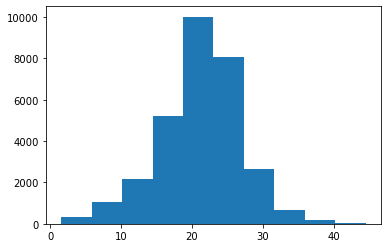

In [42]:
plt.hist(df['CPM_scaled_sqrt'])

### Potential predictors <br>
- search-term: need embedding to capture meaning? 
+ ad-creation-month (used now)
+ delivery-period (used now)
- ad-body: need text processing
+ length of text (used now)
- Image text coverage (used now)
- ad-image 
- like, follow
- targeting type

(array([15530.,     0.,  5172.,     0.,     0.,  5132.,     0.,  3865.,
            0.,   733.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

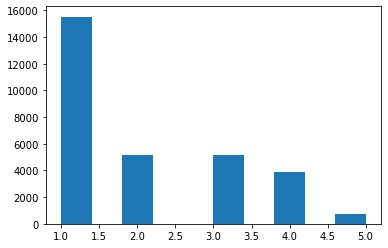

In [43]:
plt.hist(df['text_length_score'])

<AxesSubplot:>

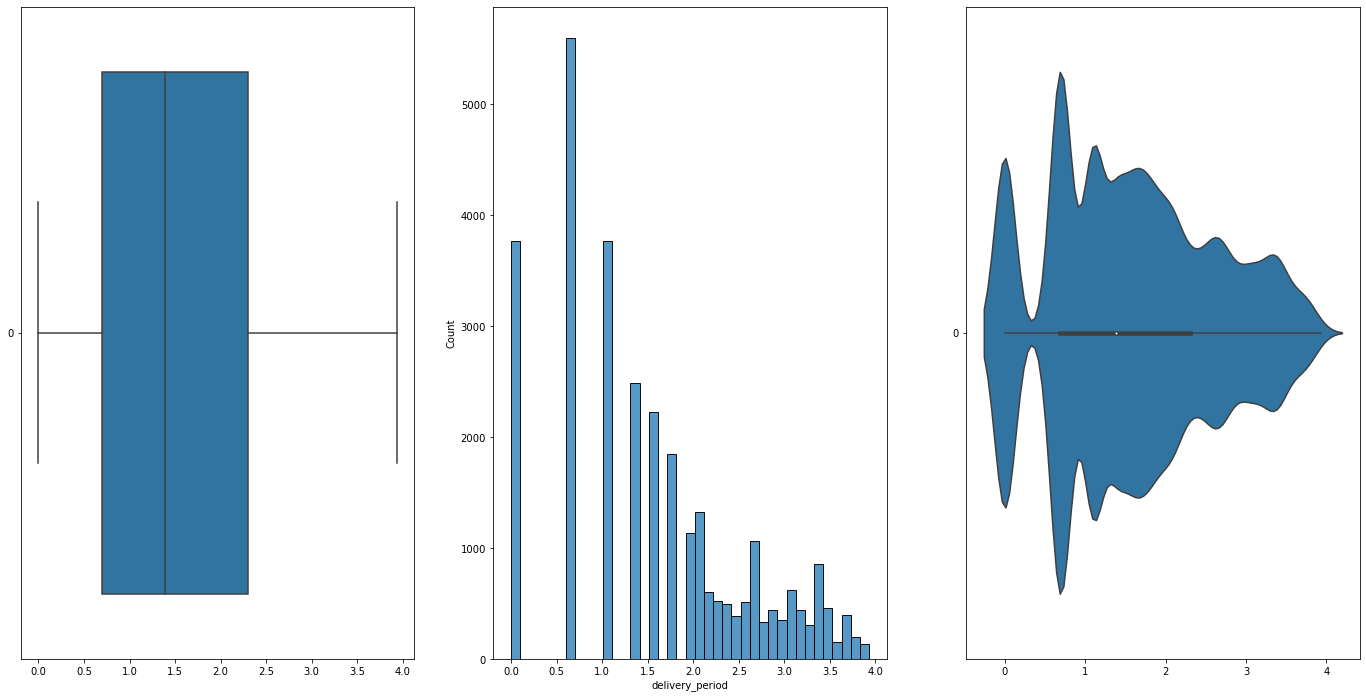

In [44]:
f, axes = plt.subplots(1, 3, figsize=(24, 12))
sb.boxplot(data = df['delivery_period'], orient = "h", ax = axes[0])
sb.histplot(data = df['delivery_period'], ax = axes[1])
sb.violinplot(data = df['delivery_period'], orient = "h", ax = axes[2])

In [16]:
df['ad_creation_month'].value_counts()

4     3929
10    3420
9     3283
5     3154
3     2708
6     2687
7     2604
8     2601
2     2432
1     1638
11    1423
12    1087
Name: ad_creation_month, dtype: int64

In [17]:
# text_percentage = []
# IMG_DIR = "Y:/Internship/SoMin/Image"
# for i in range(df.shape[0]):
#     try:
#         cover = utils.text_coverage(f'{IMG_DIR}/{df.iloc[i].ad_id}.png')
#         text_percentage.append(cover)
#     except:
#         text_percentage.append(200)

In [18]:
# df['text_percentage'] = pd.DataFrame(np.array(text_percentage))
# df = df[df['text_percentage'] <=100 ]
# df.shape

In [19]:
# df = df[(np.abs(stats.zscore(df['text_percentage'])) < 2)]
# df.shape

In [20]:
# df.to_csv("Y:/Internship/SoMin/data/df_cpm_scaled_valid_img.csv")
# utils.save_pickle(df, 'Y:/Internship/SoMin/data/df_cpm_scaled_valid_img.pkl')

In [51]:
y = pd.DataFrame(df["CPM_scaled_sqrt_bin"])
X = pd.DataFrame(df[["ad_creation_month", "text_length_score", "delivery_period", "text_percentage"]])

In [48]:
for i in range(df.shape[0]):
    if type(df.iloc[i].CPM_scaled_sqrt_bin)!='int64':
        print(i, type(df.iloc[i].CPM_scaled_sqrt_bin), df.iloc[i].CPM_scaled_sqrt_bin)

0 <class 'numpy.int64'> 1
1 <class 'numpy.int64'> 2
2 <class 'numpy.int64'> 1
3 <class 'numpy.int64'> 1
4 <class 'numpy.int64'> 2
5 <class 'numpy.int64'> 2
6 <class 'numpy.int64'> 1
7 <class 'numpy.int64'> 2
8 <class 'numpy.int64'> 1
9 <class 'numpy.int64'> 2
10 <class 'numpy.int64'> 2
11 <class 'numpy.int64'> 1
12 <class 'numpy.int64'> 2
13 <class 'numpy.int64'> 1
14 <class 'numpy.int64'> 1
15 <class 'numpy.int64'> 1
16 <class 'numpy.int64'> 1
17 <class 'numpy.int64'> 2
18 <class 'numpy.int64'> 2
19 <class 'numpy.int64'> 1
20 <class 'numpy.int64'> 1
21 <class 'numpy.int64'> 1
22 <class 'numpy.int64'> 1
23 <class 'numpy.int64'> 2
24 <class 'numpy.int64'> 2
25 <class 'numpy.int64'> 2
26 <class 'numpy.int64'> 2
27 <class 'numpy.int64'> 2
28 <class 'numpy.int64'> 2
29 <class 'numpy.int64'> 2
30 <class 'numpy.int64'> 2
31 <class 'numpy.int64'> 2
32 <class 'numpy.int64'> 2
33 <class 'numpy.int64'> 1
34 <class 'numpy.int64'> 1
35 <class 'numpy.int64'> 1
36 <class 'numpy.int64'> 2
37 <class '

356 <class 'numpy.int64'> 0
357 <class 'numpy.int64'> 2
358 <class 'numpy.int64'> 1
359 <class 'numpy.int64'> 0
360 <class 'numpy.int64'> 1
361 <class 'numpy.int64'> 1
362 <class 'numpy.int64'> 1
363 <class 'numpy.int64'> 0
364 <class 'numpy.int64'> 2
365 <class 'numpy.int64'> 1
366 <class 'numpy.int64'> 2
367 <class 'numpy.int64'> 1
368 <class 'numpy.int64'> 2
369 <class 'numpy.int64'> 1
370 <class 'numpy.int64'> 2
371 <class 'numpy.int64'> 2
372 <class 'numpy.int64'> 2
373 <class 'numpy.int64'> 1
374 <class 'numpy.int64'> 1
375 <class 'numpy.int64'> 1
376 <class 'numpy.int64'> 2
377 <class 'numpy.int64'> 2
378 <class 'numpy.int64'> 0
379 <class 'numpy.int64'> 2
380 <class 'numpy.int64'> 1
381 <class 'numpy.int64'> 2
382 <class 'numpy.int64'> 1
383 <class 'numpy.int64'> 2
384 <class 'numpy.int64'> 1
385 <class 'numpy.int64'> 1
386 <class 'numpy.int64'> 0
387 <class 'numpy.int64'> 0
388 <class 'numpy.int64'> 1
389 <class 'numpy.int64'> 2
390 <class 'numpy.int64'> 2
391 <class 'numpy.in

701 <class 'numpy.int64'> 2
702 <class 'numpy.int64'> 1
703 <class 'numpy.int64'> 2
704 <class 'numpy.int64'> 2
705 <class 'numpy.int64'> 2
706 <class 'numpy.int64'> 2
707 <class 'numpy.int64'> 2
708 <class 'numpy.int64'> 2
709 <class 'numpy.int64'> 3
710 <class 'numpy.int64'> 2
711 <class 'numpy.int64'> 1
712 <class 'numpy.int64'> 3
713 <class 'numpy.int64'> 2
714 <class 'numpy.int64'> 2
715 <class 'numpy.int64'> 2
716 <class 'numpy.int64'> 2
717 <class 'numpy.int64'> 2
718 <class 'numpy.int64'> 2
719 <class 'numpy.int64'> 2
720 <class 'numpy.int64'> 1
721 <class 'numpy.int64'> 1
722 <class 'numpy.int64'> 1
723 <class 'numpy.int64'> 2
724 <class 'numpy.int64'> 1
725 <class 'numpy.int64'> 1
726 <class 'numpy.int64'> 1
727 <class 'numpy.int64'> 1
728 <class 'numpy.int64'> 1
729 <class 'numpy.int64'> 1
730 <class 'numpy.int64'> 1
731 <class 'numpy.int64'> 1
732 <class 'numpy.int64'> 1
733 <class 'numpy.int64'> 1
734 <class 'numpy.int64'> 1
735 <class 'numpy.int64'> 1
736 <class 'numpy.in

1018 <class 'numpy.int64'> 1
1019 <class 'numpy.int64'> 1
1020 <class 'numpy.int64'> 1
1021 <class 'numpy.int64'> 2
1022 <class 'numpy.int64'> 2
1023 <class 'numpy.int64'> 2
1024 <class 'numpy.int64'> 2
1025 <class 'numpy.int64'> 1
1026 <class 'numpy.int64'> 1
1027 <class 'numpy.int64'> 2
1028 <class 'numpy.int64'> 1
1029 <class 'numpy.int64'> 1
1030 <class 'numpy.int64'> 2
1031 <class 'numpy.int64'> 1
1032 <class 'numpy.int64'> 2
1033 <class 'numpy.int64'> 2
1034 <class 'numpy.int64'> 1
1035 <class 'numpy.int64'> 2
1036 <class 'numpy.int64'> 2
1037 <class 'numpy.int64'> 2
1038 <class 'numpy.int64'> 1
1039 <class 'numpy.int64'> 2
1040 <class 'numpy.int64'> 1
1041 <class 'numpy.int64'> 2
1042 <class 'numpy.int64'> 1
1043 <class 'numpy.int64'> 1
1044 <class 'numpy.int64'> 1
1045 <class 'numpy.int64'> 1
1046 <class 'numpy.int64'> 1
1047 <class 'numpy.int64'> 1
1048 <class 'numpy.int64'> 2
1049 <class 'numpy.int64'> 2
1050 <class 'numpy.int64'> 1
1051 <class 'numpy.int64'> 2
1052 <class 'n

1319 <class 'numpy.int64'> 1
1320 <class 'numpy.int64'> 1
1321 <class 'numpy.int64'> 2
1322 <class 'numpy.int64'> 2
1323 <class 'numpy.int64'> 2
1324 <class 'numpy.int64'> 1
1325 <class 'numpy.int64'> 1
1326 <class 'numpy.int64'> 2
1327 <class 'numpy.int64'> 1
1328 <class 'numpy.int64'> 2
1329 <class 'numpy.int64'> 1
1330 <class 'numpy.int64'> 1
1331 <class 'numpy.int64'> 2
1332 <class 'numpy.int64'> 2
1333 <class 'numpy.int64'> 1
1334 <class 'numpy.int64'> 2
1335 <class 'numpy.int64'> 2
1336 <class 'numpy.int64'> 1
1337 <class 'numpy.int64'> 2
1338 <class 'numpy.int64'> 2
1339 <class 'numpy.int64'> 1
1340 <class 'numpy.int64'> 1
1341 <class 'numpy.int64'> 2
1342 <class 'numpy.int64'> 2
1343 <class 'numpy.int64'> 3
1344 <class 'numpy.int64'> 2
1345 <class 'numpy.int64'> 2
1346 <class 'numpy.int64'> 1
1347 <class 'numpy.int64'> 3
1348 <class 'numpy.int64'> 2
1349 <class 'numpy.int64'> 1
1350 <class 'numpy.int64'> 2
1351 <class 'numpy.int64'> 2
1352 <class 'numpy.int64'> 3
1353 <class 'n

1654 <class 'numpy.int64'> 1
1655 <class 'numpy.int64'> 1
1656 <class 'numpy.int64'> 1
1657 <class 'numpy.int64'> 1
1658 <class 'numpy.int64'> 1
1659 <class 'numpy.int64'> 1
1660 <class 'numpy.int64'> 2
1661 <class 'numpy.int64'> 1
1662 <class 'numpy.int64'> 1
1663 <class 'numpy.int64'> 1
1664 <class 'numpy.int64'> 1
1665 <class 'numpy.int64'> 1
1666 <class 'numpy.int64'> 1
1667 <class 'numpy.int64'> 2
1668 <class 'numpy.int64'> 2
1669 <class 'numpy.int64'> 2
1670 <class 'numpy.int64'> 2
1671 <class 'numpy.int64'> 2
1672 <class 'numpy.int64'> 2
1673 <class 'numpy.int64'> 3
1674 <class 'numpy.int64'> 2
1675 <class 'numpy.int64'> 2
1676 <class 'numpy.int64'> 2
1677 <class 'numpy.int64'> 3
1678 <class 'numpy.int64'> 3
1679 <class 'numpy.int64'> 2
1680 <class 'numpy.int64'> 3
1681 <class 'numpy.int64'> 2
1682 <class 'numpy.int64'> 3
1683 <class 'numpy.int64'> 2
1684 <class 'numpy.int64'> 2
1685 <class 'numpy.int64'> 2
1686 <class 'numpy.int64'> 2
1687 <class 'numpy.int64'> 2
1688 <class 'n

1988 <class 'numpy.int64'> 3
1989 <class 'numpy.int64'> 2
1990 <class 'numpy.int64'> 2
1991 <class 'numpy.int64'> 1
1992 <class 'numpy.int64'> 2
1993 <class 'numpy.int64'> 1
1994 <class 'numpy.int64'> 2
1995 <class 'numpy.int64'> 2
1996 <class 'numpy.int64'> 2
1997 <class 'numpy.int64'> 2
1998 <class 'numpy.int64'> 2
1999 <class 'numpy.int64'> 2
2000 <class 'numpy.int64'> 1
2001 <class 'numpy.int64'> 1
2002 <class 'numpy.int64'> 1
2003 <class 'numpy.int64'> 1
2004 <class 'numpy.int64'> 1
2005 <class 'numpy.int64'> 1
2006 <class 'numpy.int64'> 2
2007 <class 'numpy.int64'> 2
2008 <class 'numpy.int64'> 2
2009 <class 'numpy.int64'> 1
2010 <class 'numpy.int64'> 2
2011 <class 'numpy.int64'> 1
2012 <class 'numpy.int64'> 1
2013 <class 'numpy.int64'> 2
2014 <class 'numpy.int64'> 2
2015 <class 'numpy.int64'> 1
2016 <class 'numpy.int64'> 3
2017 <class 'numpy.int64'> 3
2018 <class 'numpy.int64'> 2
2019 <class 'numpy.int64'> 2
2020 <class 'numpy.int64'> 2
2021 <class 'numpy.int64'> 2
2022 <class 'n

2290 <class 'numpy.int64'> 2
2291 <class 'numpy.int64'> 2
2292 <class 'numpy.int64'> 2
2293 <class 'numpy.int64'> 1
2294 <class 'numpy.int64'> 2
2295 <class 'numpy.int64'> 2
2296 <class 'numpy.int64'> 1
2297 <class 'numpy.int64'> 2
2298 <class 'numpy.int64'> 2
2299 <class 'numpy.int64'> 2
2300 <class 'numpy.int64'> 2
2301 <class 'numpy.int64'> 2
2302 <class 'numpy.int64'> 1
2303 <class 'numpy.int64'> 2
2304 <class 'numpy.int64'> 2
2305 <class 'numpy.int64'> 2
2306 <class 'numpy.int64'> 2
2307 <class 'numpy.int64'> 1
2308 <class 'numpy.int64'> 1
2309 <class 'numpy.int64'> 1
2310 <class 'numpy.int64'> 2
2311 <class 'numpy.int64'> 1
2312 <class 'numpy.int64'> 1
2313 <class 'numpy.int64'> 1
2314 <class 'numpy.int64'> 1
2315 <class 'numpy.int64'> 2
2316 <class 'numpy.int64'> 2
2317 <class 'numpy.int64'> 2
2318 <class 'numpy.int64'> 2
2319 <class 'numpy.int64'> 2
2320 <class 'numpy.int64'> 2
2321 <class 'numpy.int64'> 2
2322 <class 'numpy.int64'> 1
2323 <class 'numpy.int64'> 2
2324 <class 'n

2598 <class 'numpy.int64'> 2
2599 <class 'numpy.int64'> 2
2600 <class 'numpy.int64'> 2
2601 <class 'numpy.int64'> 2
2602 <class 'numpy.int64'> 2
2603 <class 'numpy.int64'> 2
2604 <class 'numpy.int64'> 2
2605 <class 'numpy.int64'> 2
2606 <class 'numpy.int64'> 2
2607 <class 'numpy.int64'> 2
2608 <class 'numpy.int64'> 2
2609 <class 'numpy.int64'> 2
2610 <class 'numpy.int64'> 2
2611 <class 'numpy.int64'> 2
2612 <class 'numpy.int64'> 2
2613 <class 'numpy.int64'> 2
2614 <class 'numpy.int64'> 2
2615 <class 'numpy.int64'> 2
2616 <class 'numpy.int64'> 2
2617 <class 'numpy.int64'> 2
2618 <class 'numpy.int64'> 2
2619 <class 'numpy.int64'> 2
2620 <class 'numpy.int64'> 2
2621 <class 'numpy.int64'> 2
2622 <class 'numpy.int64'> 2
2623 <class 'numpy.int64'> 2
2624 <class 'numpy.int64'> 2
2625 <class 'numpy.int64'> 1
2626 <class 'numpy.int64'> 2
2627 <class 'numpy.int64'> 2
2628 <class 'numpy.int64'> 2
2629 <class 'numpy.int64'> 1
2630 <class 'numpy.int64'> 1
2631 <class 'numpy.int64'> 1
2632 <class 'n

2965 <class 'numpy.int64'> 1
2966 <class 'numpy.int64'> 1
2967 <class 'numpy.int64'> 2
2968 <class 'numpy.int64'> 2
2969 <class 'numpy.int64'> 3
2970 <class 'numpy.int64'> 2
2971 <class 'numpy.int64'> 2
2972 <class 'numpy.int64'> 2
2973 <class 'numpy.int64'> 2
2974 <class 'numpy.int64'> 2
2975 <class 'numpy.int64'> 2
2976 <class 'numpy.int64'> 1
2977 <class 'numpy.int64'> 3
2978 <class 'numpy.int64'> 2
2979 <class 'numpy.int64'> 2
2980 <class 'numpy.int64'> 1
2981 <class 'numpy.int64'> 1
2982 <class 'numpy.int64'> 1
2983 <class 'numpy.int64'> 1
2984 <class 'numpy.int64'> 1
2985 <class 'numpy.int64'> 1
2986 <class 'numpy.int64'> 2
2987 <class 'numpy.int64'> 1
2988 <class 'numpy.int64'> 1
2989 <class 'numpy.int64'> 1
2990 <class 'numpy.int64'> 1
2991 <class 'numpy.int64'> 1
2992 <class 'numpy.int64'> 2
2993 <class 'numpy.int64'> 2
2994 <class 'numpy.int64'> 1
2995 <class 'numpy.int64'> 2
2996 <class 'numpy.int64'> 1
2997 <class 'numpy.int64'> 2
2998 <class 'numpy.int64'> 1
2999 <class 'n

3313 <class 'numpy.int64'> 1
3314 <class 'numpy.int64'> 1
3315 <class 'numpy.int64'> 2
3316 <class 'numpy.int64'> 2
3317 <class 'numpy.int64'> 2
3318 <class 'numpy.int64'> 1
3319 <class 'numpy.int64'> 1
3320 <class 'numpy.int64'> 2
3321 <class 'numpy.int64'> 2
3322 <class 'numpy.int64'> 2
3323 <class 'numpy.int64'> 2
3324 <class 'numpy.int64'> 1
3325 <class 'numpy.int64'> 1
3326 <class 'numpy.int64'> 2
3327 <class 'numpy.int64'> 1
3328 <class 'numpy.int64'> 1
3329 <class 'numpy.int64'> 1
3330 <class 'numpy.int64'> 2
3331 <class 'numpy.int64'> 2
3332 <class 'numpy.int64'> 1
3333 <class 'numpy.int64'> 1
3334 <class 'numpy.int64'> 1
3335 <class 'numpy.int64'> 3
3336 <class 'numpy.int64'> 2
3337 <class 'numpy.int64'> 2
3338 <class 'numpy.int64'> 1
3339 <class 'numpy.int64'> 1
3340 <class 'numpy.int64'> 2
3341 <class 'numpy.int64'> 1
3342 <class 'numpy.int64'> 2
3343 <class 'numpy.int64'> 2
3344 <class 'numpy.int64'> 2
3345 <class 'numpy.int64'> 1
3346 <class 'numpy.int64'> 2
3347 <class 'n

3602 <class 'numpy.int64'> 1
3603 <class 'numpy.int64'> 1
3604 <class 'numpy.int64'> 1
3605 <class 'numpy.int64'> 2
3606 <class 'numpy.int64'> 2
3607 <class 'numpy.int64'> 1
3608 <class 'numpy.int64'> 1
3609 <class 'numpy.int64'> 2
3610 <class 'numpy.int64'> 1
3611 <class 'numpy.int64'> 1
3612 <class 'numpy.int64'> 1
3613 <class 'numpy.int64'> 1
3614 <class 'numpy.int64'> 1
3615 <class 'numpy.int64'> 1
3616 <class 'numpy.int64'> 1
3617 <class 'numpy.int64'> 2
3618 <class 'numpy.int64'> 1
3619 <class 'numpy.int64'> 2
3620 <class 'numpy.int64'> 2
3621 <class 'numpy.int64'> 1
3622 <class 'numpy.int64'> 1
3623 <class 'numpy.int64'> 1
3624 <class 'numpy.int64'> 1
3625 <class 'numpy.int64'> 1
3626 <class 'numpy.int64'> 1
3627 <class 'numpy.int64'> 1
3628 <class 'numpy.int64'> 1
3629 <class 'numpy.int64'> 1
3630 <class 'numpy.int64'> 2
3631 <class 'numpy.int64'> 1
3632 <class 'numpy.int64'> 1
3633 <class 'numpy.int64'> 2
3634 <class 'numpy.int64'> 2
3635 <class 'numpy.int64'> 2
3636 <class 'n

3938 <class 'numpy.int64'> 2
3939 <class 'numpy.int64'> 2
3940 <class 'numpy.int64'> 2
3941 <class 'numpy.int64'> 2
3942 <class 'numpy.int64'> 1
3943 <class 'numpy.int64'> 2
3944 <class 'numpy.int64'> 2
3945 <class 'numpy.int64'> 2
3946 <class 'numpy.int64'> 2
3947 <class 'numpy.int64'> 2
3948 <class 'numpy.int64'> 2
3949 <class 'numpy.int64'> 2
3950 <class 'numpy.int64'> 2
3951 <class 'numpy.int64'> 2
3952 <class 'numpy.int64'> 2
3953 <class 'numpy.int64'> 2
3954 <class 'numpy.int64'> 2
3955 <class 'numpy.int64'> 2
3956 <class 'numpy.int64'> 2
3957 <class 'numpy.int64'> 0
3958 <class 'numpy.int64'> 0
3959 <class 'numpy.int64'> 0
3960 <class 'numpy.int64'> 0
3961 <class 'numpy.int64'> 0
3962 <class 'numpy.int64'> 0
3963 <class 'numpy.int64'> 1
3964 <class 'numpy.int64'> 0
3965 <class 'numpy.int64'> 0
3966 <class 'numpy.int64'> 2
3967 <class 'numpy.int64'> 1
3968 <class 'numpy.int64'> 2
3969 <class 'numpy.int64'> 1
3970 <class 'numpy.int64'> 3
3971 <class 'numpy.int64'> 1
3972 <class 'n

4289 <class 'numpy.int64'> 0
4290 <class 'numpy.int64'> 0
4291 <class 'numpy.int64'> 2
4292 <class 'numpy.int64'> 2
4293 <class 'numpy.int64'> 0
4294 <class 'numpy.int64'> 1
4295 <class 'numpy.int64'> 2
4296 <class 'numpy.int64'> 0
4297 <class 'numpy.int64'> 1
4298 <class 'numpy.int64'> 1
4299 <class 'numpy.int64'> 1
4300 <class 'numpy.int64'> 0
4301 <class 'numpy.int64'> 1
4302 <class 'numpy.int64'> 1
4303 <class 'numpy.int64'> 1
4304 <class 'numpy.int64'> 1
4305 <class 'numpy.int64'> 1
4306 <class 'numpy.int64'> 0
4307 <class 'numpy.int64'> 1
4308 <class 'numpy.int64'> 1
4309 <class 'numpy.int64'> 1
4310 <class 'numpy.int64'> 1
4311 <class 'numpy.int64'> 1
4312 <class 'numpy.int64'> 0
4313 <class 'numpy.int64'> 1
4314 <class 'numpy.int64'> 1
4315 <class 'numpy.int64'> 1
4316 <class 'numpy.int64'> 0
4317 <class 'numpy.int64'> 1
4318 <class 'numpy.int64'> 1
4319 <class 'numpy.int64'> 0
4320 <class 'numpy.int64'> 1
4321 <class 'numpy.int64'> 0
4322 <class 'numpy.int64'> 1
4323 <class 'n

4616 <class 'numpy.int64'> 2
4617 <class 'numpy.int64'> 2
4618 <class 'numpy.int64'> 2
4619 <class 'numpy.int64'> 1
4620 <class 'numpy.int64'> 2
4621 <class 'numpy.int64'> 1
4622 <class 'numpy.int64'> 2
4623 <class 'numpy.int64'> 2
4624 <class 'numpy.int64'> 2
4625 <class 'numpy.int64'> 2
4626 <class 'numpy.int64'> 2
4627 <class 'numpy.int64'> 0
4628 <class 'numpy.int64'> 1
4629 <class 'numpy.int64'> 0
4630 <class 'numpy.int64'> 1
4631 <class 'numpy.int64'> 0
4632 <class 'numpy.int64'> 0
4633 <class 'numpy.int64'> 0
4634 <class 'numpy.int64'> 0
4635 <class 'numpy.int64'> 0
4636 <class 'numpy.int64'> 0
4637 <class 'numpy.int64'> 0
4638 <class 'numpy.int64'> 0
4639 <class 'numpy.int64'> 0
4640 <class 'numpy.int64'> 0
4641 <class 'numpy.int64'> 0
4642 <class 'numpy.int64'> 0
4643 <class 'numpy.int64'> 2
4644 <class 'numpy.int64'> 0
4645 <class 'numpy.int64'> 0
4646 <class 'numpy.int64'> 0
4647 <class 'numpy.int64'> 0
4648 <class 'numpy.int64'> 0
4649 <class 'numpy.int64'> 0
4650 <class 'n

4944 <class 'numpy.int64'> 1
4945 <class 'numpy.int64'> 1
4946 <class 'numpy.int64'> 1
4947 <class 'numpy.int64'> 1
4948 <class 'numpy.int64'> 1
4949 <class 'numpy.int64'> 1
4950 <class 'numpy.int64'> 1
4951 <class 'numpy.int64'> 1
4952 <class 'numpy.int64'> 1
4953 <class 'numpy.int64'> 1
4954 <class 'numpy.int64'> 1
4955 <class 'numpy.int64'> 1
4956 <class 'numpy.int64'> 1
4957 <class 'numpy.int64'> 1
4958 <class 'numpy.int64'> 1
4959 <class 'numpy.int64'> 1
4960 <class 'numpy.int64'> 1
4961 <class 'numpy.int64'> 1
4962 <class 'numpy.int64'> 1
4963 <class 'numpy.int64'> 1
4964 <class 'numpy.int64'> 1
4965 <class 'numpy.int64'> 1
4966 <class 'numpy.int64'> 1
4967 <class 'numpy.int64'> 1
4968 <class 'numpy.int64'> 1
4969 <class 'numpy.int64'> 1
4970 <class 'numpy.int64'> 2
4971 <class 'numpy.int64'> 0
4972 <class 'numpy.int64'> 0
4973 <class 'numpy.int64'> 0
4974 <class 'numpy.int64'> 0
4975 <class 'numpy.int64'> 0
4976 <class 'numpy.int64'> 0
4977 <class 'numpy.int64'> 0
4978 <class 'n

5235 <class 'numpy.int64'> 1
5236 <class 'numpy.int64'> 2
5237 <class 'numpy.int64'> 2
5238 <class 'numpy.int64'> 1
5239 <class 'numpy.int64'> 2
5240 <class 'numpy.int64'> 1
5241 <class 'numpy.int64'> 2
5242 <class 'numpy.int64'> 2
5243 <class 'numpy.int64'> 2
5244 <class 'numpy.int64'> 1
5245 <class 'numpy.int64'> 2
5246 <class 'numpy.int64'> 2
5247 <class 'numpy.int64'> 1
5248 <class 'numpy.int64'> 2
5249 <class 'numpy.int64'> 2
5250 <class 'numpy.int64'> 1
5251 <class 'numpy.int64'> 2
5252 <class 'numpy.int64'> 1
5253 <class 'numpy.int64'> 0
5254 <class 'numpy.int64'> 1
5255 <class 'numpy.int64'> 0
5256 <class 'numpy.int64'> 1
5257 <class 'numpy.int64'> 1
5258 <class 'numpy.int64'> 1
5259 <class 'numpy.int64'> 1
5260 <class 'numpy.int64'> 1
5261 <class 'numpy.int64'> 1
5262 <class 'numpy.int64'> 1
5263 <class 'numpy.int64'> 1
5264 <class 'numpy.int64'> 2
5265 <class 'numpy.int64'> 2
5266 <class 'numpy.int64'> 2
5267 <class 'numpy.int64'> 1
5268 <class 'numpy.int64'> 1
5269 <class 'n

5529 <class 'numpy.int64'> 2
5530 <class 'numpy.int64'> 2
5531 <class 'numpy.int64'> 2
5532 <class 'numpy.int64'> 2
5533 <class 'numpy.int64'> 2
5534 <class 'numpy.int64'> 2
5535 <class 'numpy.int64'> 1
5536 <class 'numpy.int64'> 2
5537 <class 'numpy.int64'> 2
5538 <class 'numpy.int64'> 1
5539 <class 'numpy.int64'> 2
5540 <class 'numpy.int64'> 2
5541 <class 'numpy.int64'> 1
5542 <class 'numpy.int64'> 2
5543 <class 'numpy.int64'> 1
5544 <class 'numpy.int64'> 2
5545 <class 'numpy.int64'> 1
5546 <class 'numpy.int64'> 2
5547 <class 'numpy.int64'> 2
5548 <class 'numpy.int64'> 2
5549 <class 'numpy.int64'> 2
5550 <class 'numpy.int64'> 2
5551 <class 'numpy.int64'> 1
5552 <class 'numpy.int64'> 2
5553 <class 'numpy.int64'> 1
5554 <class 'numpy.int64'> 1
5555 <class 'numpy.int64'> 2
5556 <class 'numpy.int64'> 2
5557 <class 'numpy.int64'> 2
5558 <class 'numpy.int64'> 2
5559 <class 'numpy.int64'> 2
5560 <class 'numpy.int64'> 2
5561 <class 'numpy.int64'> 2
5562 <class 'numpy.int64'> 2
5563 <class 'n

5813 <class 'numpy.int64'> 2
5814 <class 'numpy.int64'> 2
5815 <class 'numpy.int64'> 3
5816 <class 'numpy.int64'> 2
5817 <class 'numpy.int64'> 3
5818 <class 'numpy.int64'> 3
5819 <class 'numpy.int64'> 2
5820 <class 'numpy.int64'> 2
5821 <class 'numpy.int64'> 3
5822 <class 'numpy.int64'> 3
5823 <class 'numpy.int64'> 3
5824 <class 'numpy.int64'> 3
5825 <class 'numpy.int64'> 3
5826 <class 'numpy.int64'> 2
5827 <class 'numpy.int64'> 2
5828 <class 'numpy.int64'> 3
5829 <class 'numpy.int64'> 2
5830 <class 'numpy.int64'> 2
5831 <class 'numpy.int64'> 3
5832 <class 'numpy.int64'> 1
5833 <class 'numpy.int64'> 2
5834 <class 'numpy.int64'> 3
5835 <class 'numpy.int64'> 2
5836 <class 'numpy.int64'> 2
5837 <class 'numpy.int64'> 1
5838 <class 'numpy.int64'> 0
5839 <class 'numpy.int64'> 0
5840 <class 'numpy.int64'> 2
5841 <class 'numpy.int64'> 3
5842 <class 'numpy.int64'> 1
5843 <class 'numpy.int64'> 1
5844 <class 'numpy.int64'> 3
5845 <class 'numpy.int64'> 2
5846 <class 'numpy.int64'> 2
5847 <class 'n

6140 <class 'numpy.int64'> 2
6141 <class 'numpy.int64'> 2
6142 <class 'numpy.int64'> 1
6143 <class 'numpy.int64'> 2
6144 <class 'numpy.int64'> 2
6145 <class 'numpy.int64'> 2
6146 <class 'numpy.int64'> 3
6147 <class 'numpy.int64'> 2
6148 <class 'numpy.int64'> 2
6149 <class 'numpy.int64'> 2
6150 <class 'numpy.int64'> 2
6151 <class 'numpy.int64'> 2
6152 <class 'numpy.int64'> 2
6153 <class 'numpy.int64'> 1
6154 <class 'numpy.int64'> 0
6155 <class 'numpy.int64'> 2
6156 <class 'numpy.int64'> 2
6157 <class 'numpy.int64'> 2
6158 <class 'numpy.int64'> 3
6159 <class 'numpy.int64'> 1
6160 <class 'numpy.int64'> 1
6161 <class 'numpy.int64'> 3
6162 <class 'numpy.int64'> 2
6163 <class 'numpy.int64'> 2
6164 <class 'numpy.int64'> 2
6165 <class 'numpy.int64'> 2
6166 <class 'numpy.int64'> 2
6167 <class 'numpy.int64'> 2
6168 <class 'numpy.int64'> 1
6169 <class 'numpy.int64'> 1
6170 <class 'numpy.int64'> 2
6171 <class 'numpy.int64'> 1
6172 <class 'numpy.int64'> 1
6173 <class 'numpy.int64'> 2
6174 <class 'n

6463 <class 'numpy.int64'> 2
6464 <class 'numpy.int64'> 1
6465 <class 'numpy.int64'> 2
6466 <class 'numpy.int64'> 2
6467 <class 'numpy.int64'> 2
6468 <class 'numpy.int64'> 2
6469 <class 'numpy.int64'> 2
6470 <class 'numpy.int64'> 3
6471 <class 'numpy.int64'> 2
6472 <class 'numpy.int64'> 2
6473 <class 'numpy.int64'> 2
6474 <class 'numpy.int64'> 2
6475 <class 'numpy.int64'> 1
6476 <class 'numpy.int64'> 2
6477 <class 'numpy.int64'> 3
6478 <class 'numpy.int64'> 2
6479 <class 'numpy.int64'> 2
6480 <class 'numpy.int64'> 2
6481 <class 'numpy.int64'> 2
6482 <class 'numpy.int64'> 0
6483 <class 'numpy.int64'> 1
6484 <class 'numpy.int64'> 2
6485 <class 'numpy.int64'> 2
6486 <class 'numpy.int64'> 2
6487 <class 'numpy.int64'> 1
6488 <class 'numpy.int64'> 2
6489 <class 'numpy.int64'> 2
6490 <class 'numpy.int64'> 2
6491 <class 'numpy.int64'> 2
6492 <class 'numpy.int64'> 2
6493 <class 'numpy.int64'> 2
6494 <class 'numpy.int64'> 1
6495 <class 'numpy.int64'> 1
6496 <class 'numpy.int64'> 2
6497 <class 'n

7061 <class 'numpy.int64'> 1
7062 <class 'numpy.int64'> 1
7063 <class 'numpy.int64'> 1
7064 <class 'numpy.int64'> 2
7065 <class 'numpy.int64'> 2
7066 <class 'numpy.int64'> 1
7067 <class 'numpy.int64'> 2
7068 <class 'numpy.int64'> 1
7069 <class 'numpy.int64'> 2
7070 <class 'numpy.int64'> 2
7071 <class 'numpy.int64'> 1
7072 <class 'numpy.int64'> 1
7073 <class 'numpy.int64'> 1
7074 <class 'numpy.int64'> 1
7075 <class 'numpy.int64'> 1
7076 <class 'numpy.int64'> 1
7077 <class 'numpy.int64'> 2
7078 <class 'numpy.int64'> 2
7079 <class 'numpy.int64'> 2
7080 <class 'numpy.int64'> 2
7081 <class 'numpy.int64'> 1
7082 <class 'numpy.int64'> 3
7083 <class 'numpy.int64'> 1
7084 <class 'numpy.int64'> 1
7085 <class 'numpy.int64'> 1
7086 <class 'numpy.int64'> 2
7087 <class 'numpy.int64'> 1
7088 <class 'numpy.int64'> 1
7089 <class 'numpy.int64'> 1
7090 <class 'numpy.int64'> 1
7091 <class 'numpy.int64'> 1
7092 <class 'numpy.int64'> 1
7093 <class 'numpy.int64'> 1
7094 <class 'numpy.int64'> 1
7095 <class 'n

7376 <class 'numpy.int64'> 1
7377 <class 'numpy.int64'> 1
7378 <class 'numpy.int64'> 1
7379 <class 'numpy.int64'> 1
7380 <class 'numpy.int64'> 1
7381 <class 'numpy.int64'> 1
7382 <class 'numpy.int64'> 1
7383 <class 'numpy.int64'> 1
7384 <class 'numpy.int64'> 1
7385 <class 'numpy.int64'> 1
7386 <class 'numpy.int64'> 2
7387 <class 'numpy.int64'> 1
7388 <class 'numpy.int64'> 1
7389 <class 'numpy.int64'> 1
7390 <class 'numpy.int64'> 1
7391 <class 'numpy.int64'> 1
7392 <class 'numpy.int64'> 1
7393 <class 'numpy.int64'> 1
7394 <class 'numpy.int64'> 1
7395 <class 'numpy.int64'> 1
7396 <class 'numpy.int64'> 1
7397 <class 'numpy.int64'> 1
7398 <class 'numpy.int64'> 1
7399 <class 'numpy.int64'> 2
7400 <class 'numpy.int64'> 2
7401 <class 'numpy.int64'> 2
7402 <class 'numpy.int64'> 2
7403 <class 'numpy.int64'> 2
7404 <class 'numpy.int64'> 1
7405 <class 'numpy.int64'> 1
7406 <class 'numpy.int64'> 2
7407 <class 'numpy.int64'> 2
7408 <class 'numpy.int64'> 2
7409 <class 'numpy.int64'> 2
7410 <class 'n

7673 <class 'numpy.int64'> 2
7674 <class 'numpy.int64'> 2
7675 <class 'numpy.int64'> 2
7676 <class 'numpy.int64'> 1
7677 <class 'numpy.int64'> 1
7678 <class 'numpy.int64'> 1
7679 <class 'numpy.int64'> 1
7680 <class 'numpy.int64'> 1
7681 <class 'numpy.int64'> 2
7682 <class 'numpy.int64'> 2
7683 <class 'numpy.int64'> 1
7684 <class 'numpy.int64'> 2
7685 <class 'numpy.int64'> 1
7686 <class 'numpy.int64'> 1
7687 <class 'numpy.int64'> 1
7688 <class 'numpy.int64'> 1
7689 <class 'numpy.int64'> 1
7690 <class 'numpy.int64'> 2
7691 <class 'numpy.int64'> 1
7692 <class 'numpy.int64'> 1
7693 <class 'numpy.int64'> 2
7694 <class 'numpy.int64'> 3
7695 <class 'numpy.int64'> 2
7696 <class 'numpy.int64'> 3
7697 <class 'numpy.int64'> 2
7698 <class 'numpy.int64'> 2
7699 <class 'numpy.int64'> 2
7700 <class 'numpy.int64'> 2
7701 <class 'numpy.int64'> 2
7702 <class 'numpy.int64'> 1
7703 <class 'numpy.int64'> 1
7704 <class 'numpy.int64'> 2
7705 <class 'numpy.int64'> 2
7706 <class 'numpy.int64'> 2
7707 <class 'n

8023 <class 'numpy.int64'> 1
8024 <class 'numpy.int64'> 1
8025 <class 'numpy.int64'> 2
8026 <class 'numpy.int64'> 1
8027 <class 'numpy.int64'> 1
8028 <class 'numpy.int64'> 1
8029 <class 'numpy.int64'> 1
8030 <class 'numpy.int64'> 1
8031 <class 'numpy.int64'> 1
8032 <class 'numpy.int64'> 1
8033 <class 'numpy.int64'> 2
8034 <class 'numpy.int64'> 1
8035 <class 'numpy.int64'> 1
8036 <class 'numpy.int64'> 1
8037 <class 'numpy.int64'> 1
8038 <class 'numpy.int64'> 1
8039 <class 'numpy.int64'> 1
8040 <class 'numpy.int64'> 2
8041 <class 'numpy.int64'> 3
8042 <class 'numpy.int64'> 2
8043 <class 'numpy.int64'> 2
8044 <class 'numpy.int64'> 2
8045 <class 'numpy.int64'> 3
8046 <class 'numpy.int64'> 2
8047 <class 'numpy.int64'> 2
8048 <class 'numpy.int64'> 2
8049 <class 'numpy.int64'> 2
8050 <class 'numpy.int64'> 2
8051 <class 'numpy.int64'> 2
8052 <class 'numpy.int64'> 2
8053 <class 'numpy.int64'> 2
8054 <class 'numpy.int64'> 2
8055 <class 'numpy.int64'> 3
8056 <class 'numpy.int64'> 2
8057 <class 'n

8341 <class 'numpy.int64'> 2
8342 <class 'numpy.int64'> 2
8343 <class 'numpy.int64'> 2
8344 <class 'numpy.int64'> 1
8345 <class 'numpy.int64'> 1
8346 <class 'numpy.int64'> 2
8347 <class 'numpy.int64'> 1
8348 <class 'numpy.int64'> 1
8349 <class 'numpy.int64'> 1
8350 <class 'numpy.int64'> 1
8351 <class 'numpy.int64'> 1
8352 <class 'numpy.int64'> 2
8353 <class 'numpy.int64'> 2
8354 <class 'numpy.int64'> 2
8355 <class 'numpy.int64'> 1
8356 <class 'numpy.int64'> 2
8357 <class 'numpy.int64'> 2
8358 <class 'numpy.int64'> 2
8359 <class 'numpy.int64'> 2
8360 <class 'numpy.int64'> 2
8361 <class 'numpy.int64'> 2
8362 <class 'numpy.int64'> 0
8363 <class 'numpy.int64'> 0
8364 <class 'numpy.int64'> 0
8365 <class 'numpy.int64'> 2
8366 <class 'numpy.int64'> 0
8367 <class 'numpy.int64'> 0
8368 <class 'numpy.int64'> 1
8369 <class 'numpy.int64'> 2
8370 <class 'numpy.int64'> 2
8371 <class 'numpy.int64'> 2
8372 <class 'numpy.int64'> 2
8373 <class 'numpy.int64'> 2
8374 <class 'numpy.int64'> 2
8375 <class 'n

8701 <class 'numpy.int64'> 1
8702 <class 'numpy.int64'> 2
8703 <class 'numpy.int64'> 2
8704 <class 'numpy.int64'> 1
8705 <class 'numpy.int64'> 2
8706 <class 'numpy.int64'> 1
8707 <class 'numpy.int64'> 2
8708 <class 'numpy.int64'> 1
8709 <class 'numpy.int64'> 1
8710 <class 'numpy.int64'> 1
8711 <class 'numpy.int64'> 1
8712 <class 'numpy.int64'> 1
8713 <class 'numpy.int64'> 1
8714 <class 'numpy.int64'> 2
8715 <class 'numpy.int64'> 2
8716 <class 'numpy.int64'> 2
8717 <class 'numpy.int64'> 2
8718 <class 'numpy.int64'> 2
8719 <class 'numpy.int64'> 2
8720 <class 'numpy.int64'> 2
8721 <class 'numpy.int64'> 1
8722 <class 'numpy.int64'> 2
8723 <class 'numpy.int64'> 2
8724 <class 'numpy.int64'> 1
8725 <class 'numpy.int64'> 3
8726 <class 'numpy.int64'> 2
8727 <class 'numpy.int64'> 2
8728 <class 'numpy.int64'> 1
8729 <class 'numpy.int64'> 2
8730 <class 'numpy.int64'> 1
8731 <class 'numpy.int64'> 2
8732 <class 'numpy.int64'> 1
8733 <class 'numpy.int64'> 2
8734 <class 'numpy.int64'> 3
8735 <class 'n

9017 <class 'numpy.int64'> 1
9018 <class 'numpy.int64'> 1
9019 <class 'numpy.int64'> 1
9020 <class 'numpy.int64'> 0
9021 <class 'numpy.int64'> 2
9022 <class 'numpy.int64'> 2
9023 <class 'numpy.int64'> 2
9024 <class 'numpy.int64'> 2
9025 <class 'numpy.int64'> 2
9026 <class 'numpy.int64'> 2
9027 <class 'numpy.int64'> 2
9028 <class 'numpy.int64'> 2
9029 <class 'numpy.int64'> 2
9030 <class 'numpy.int64'> 2
9031 <class 'numpy.int64'> 2
9032 <class 'numpy.int64'> 2
9033 <class 'numpy.int64'> 1
9034 <class 'numpy.int64'> 2
9035 <class 'numpy.int64'> 2
9036 <class 'numpy.int64'> 1
9037 <class 'numpy.int64'> 1
9038 <class 'numpy.int64'> 1
9039 <class 'numpy.int64'> 2
9040 <class 'numpy.int64'> 2
9041 <class 'numpy.int64'> 1
9042 <class 'numpy.int64'> 2
9043 <class 'numpy.int64'> 2
9044 <class 'numpy.int64'> 2
9045 <class 'numpy.int64'> 2
9046 <class 'numpy.int64'> 2
9047 <class 'numpy.int64'> 2
9048 <class 'numpy.int64'> 1
9049 <class 'numpy.int64'> 1
9050 <class 'numpy.int64'> 1
9051 <class 'n

9399 <class 'numpy.int64'> 2
9400 <class 'numpy.int64'> 2
9401 <class 'numpy.int64'> 2
9402 <class 'numpy.int64'> 1
9403 <class 'numpy.int64'> 1
9404 <class 'numpy.int64'> 2
9405 <class 'numpy.int64'> 1
9406 <class 'numpy.int64'> 1
9407 <class 'numpy.int64'> 2
9408 <class 'numpy.int64'> 1
9409 <class 'numpy.int64'> 2
9410 <class 'numpy.int64'> 3
9411 <class 'numpy.int64'> 1
9412 <class 'numpy.int64'> 1
9413 <class 'numpy.int64'> 1
9414 <class 'numpy.int64'> 1
9415 <class 'numpy.int64'> 1
9416 <class 'numpy.int64'> 1
9417 <class 'numpy.int64'> 1
9418 <class 'numpy.int64'> 1
9419 <class 'numpy.int64'> 1
9420 <class 'numpy.int64'> 1
9421 <class 'numpy.int64'> 1
9422 <class 'numpy.int64'> 1
9423 <class 'numpy.int64'> 1
9424 <class 'numpy.int64'> 1
9425 <class 'numpy.int64'> 1
9426 <class 'numpy.int64'> 1
9427 <class 'numpy.int64'> 1
9428 <class 'numpy.int64'> 1
9429 <class 'numpy.int64'> 1
9430 <class 'numpy.int64'> 1
9431 <class 'numpy.int64'> 1
9432 <class 'numpy.int64'> 1
9433 <class 'n

9745 <class 'numpy.int64'> 0
9746 <class 'numpy.int64'> 0
9747 <class 'numpy.int64'> 0
9748 <class 'numpy.int64'> 1
9749 <class 'numpy.int64'> 1
9750 <class 'numpy.int64'> 1
9751 <class 'numpy.int64'> 1
9752 <class 'numpy.int64'> 0
9753 <class 'numpy.int64'> 1
9754 <class 'numpy.int64'> 1
9755 <class 'numpy.int64'> 0
9756 <class 'numpy.int64'> 0
9757 <class 'numpy.int64'> 2
9758 <class 'numpy.int64'> 2
9759 <class 'numpy.int64'> 2
9760 <class 'numpy.int64'> 2
9761 <class 'numpy.int64'> 2
9762 <class 'numpy.int64'> 2
9763 <class 'numpy.int64'> 2
9764 <class 'numpy.int64'> 1
9765 <class 'numpy.int64'> 1
9766 <class 'numpy.int64'> 2
9767 <class 'numpy.int64'> 2
9768 <class 'numpy.int64'> 1
9769 <class 'numpy.int64'> 2
9770 <class 'numpy.int64'> 2
9771 <class 'numpy.int64'> 1
9772 <class 'numpy.int64'> 1
9773 <class 'numpy.int64'> 1
9774 <class 'numpy.int64'> 2
9775 <class 'numpy.int64'> 2
9776 <class 'numpy.int64'> 2
9777 <class 'numpy.int64'> 2
9778 <class 'numpy.int64'> 2
9779 <class 'n

10030 <class 'numpy.int64'> 1
10031 <class 'numpy.int64'> 2
10032 <class 'numpy.int64'> 2
10033 <class 'numpy.int64'> 2
10034 <class 'numpy.int64'> 2
10035 <class 'numpy.int64'> 2
10036 <class 'numpy.int64'> 2
10037 <class 'numpy.int64'> 2
10038 <class 'numpy.int64'> 2
10039 <class 'numpy.int64'> 2
10040 <class 'numpy.int64'> 2
10041 <class 'numpy.int64'> 2
10042 <class 'numpy.int64'> 2
10043 <class 'numpy.int64'> 1
10044 <class 'numpy.int64'> 3
10045 <class 'numpy.int64'> 2
10046 <class 'numpy.int64'> 2
10047 <class 'numpy.int64'> 2
10048 <class 'numpy.int64'> 2
10049 <class 'numpy.int64'> 2
10050 <class 'numpy.int64'> 2
10051 <class 'numpy.int64'> 1
10052 <class 'numpy.int64'> 2
10053 <class 'numpy.int64'> 2
10054 <class 'numpy.int64'> 4
10055 <class 'numpy.int64'> 3
10056 <class 'numpy.int64'> 3
10057 <class 'numpy.int64'> 3
10058 <class 'numpy.int64'> 2
10059 <class 'numpy.int64'> 2
10060 <class 'numpy.int64'> 2
10061 <class 'numpy.int64'> 3
10062 <class 'numpy.int64'> 2
10063 <cla

10343 <class 'numpy.int64'> 3
10344 <class 'numpy.int64'> 3
10345 <class 'numpy.int64'> 3
10346 <class 'numpy.int64'> 2
10347 <class 'numpy.int64'> 3
10348 <class 'numpy.int64'> 3
10349 <class 'numpy.int64'> 3
10350 <class 'numpy.int64'> 2
10351 <class 'numpy.int64'> 3
10352 <class 'numpy.int64'> 3
10353 <class 'numpy.int64'> 2
10354 <class 'numpy.int64'> 2
10355 <class 'numpy.int64'> 3
10356 <class 'numpy.int64'> 3
10357 <class 'numpy.int64'> 3
10358 <class 'numpy.int64'> 3
10359 <class 'numpy.int64'> 3
10360 <class 'numpy.int64'> 3
10361 <class 'numpy.int64'> 2
10362 <class 'numpy.int64'> 3
10363 <class 'numpy.int64'> 4
10364 <class 'numpy.int64'> 3
10365 <class 'numpy.int64'> 2
10366 <class 'numpy.int64'> 3
10367 <class 'numpy.int64'> 3
10368 <class 'numpy.int64'> 2
10369 <class 'numpy.int64'> 2
10370 <class 'numpy.int64'> 2
10371 <class 'numpy.int64'> 3
10372 <class 'numpy.int64'> 2
10373 <class 'numpy.int64'> 3
10374 <class 'numpy.int64'> 1
10375 <class 'numpy.int64'> 2
10376 <cla

10655 <class 'numpy.int64'> 2
10656 <class 'numpy.int64'> 3
10657 <class 'numpy.int64'> 2
10658 <class 'numpy.int64'> 2
10659 <class 'numpy.int64'> 2
10660 <class 'numpy.int64'> 2
10661 <class 'numpy.int64'> 2
10662 <class 'numpy.int64'> 2
10663 <class 'numpy.int64'> 2
10664 <class 'numpy.int64'> 2
10665 <class 'numpy.int64'> 2
10666 <class 'numpy.int64'> 2
10667 <class 'numpy.int64'> 2
10668 <class 'numpy.int64'> 2
10669 <class 'numpy.int64'> 3
10670 <class 'numpy.int64'> 2
10671 <class 'numpy.int64'> 2
10672 <class 'numpy.int64'> 2
10673 <class 'numpy.int64'> 3
10674 <class 'numpy.int64'> 2
10675 <class 'numpy.int64'> 2
10676 <class 'numpy.int64'> 0
10677 <class 'numpy.int64'> 2
10678 <class 'numpy.int64'> 1
10679 <class 'numpy.int64'> 0
10680 <class 'numpy.int64'> 1
10681 <class 'numpy.int64'> 0
10682 <class 'numpy.int64'> 1
10683 <class 'numpy.int64'> 2
10684 <class 'numpy.int64'> 2
10685 <class 'numpy.int64'> 1
10686 <class 'numpy.int64'> 2
10687 <class 'numpy.int64'> 2
10688 <cla

10963 <class 'numpy.int64'> 1
10964 <class 'numpy.int64'> 2
10965 <class 'numpy.int64'> 1
10966 <class 'numpy.int64'> 1
10967 <class 'numpy.int64'> 1
10968 <class 'numpy.int64'> 1
10969 <class 'numpy.int64'> 2
10970 <class 'numpy.int64'> 2
10971 <class 'numpy.int64'> 2
10972 <class 'numpy.int64'> 2
10973 <class 'numpy.int64'> 2
10974 <class 'numpy.int64'> 2
10975 <class 'numpy.int64'> 2
10976 <class 'numpy.int64'> 2
10977 <class 'numpy.int64'> 1
10978 <class 'numpy.int64'> 1
10979 <class 'numpy.int64'> 1
10980 <class 'numpy.int64'> 1
10981 <class 'numpy.int64'> 1
10982 <class 'numpy.int64'> 1
10983 <class 'numpy.int64'> 1
10984 <class 'numpy.int64'> 1
10985 <class 'numpy.int64'> 1
10986 <class 'numpy.int64'> 1
10987 <class 'numpy.int64'> 1
10988 <class 'numpy.int64'> 1
10989 <class 'numpy.int64'> 1
10990 <class 'numpy.int64'> 1
10991 <class 'numpy.int64'> 1
10992 <class 'numpy.int64'> 1
10993 <class 'numpy.int64'> 1
10994 <class 'numpy.int64'> 1
10995 <class 'numpy.int64'> 1
10996 <cla

11242 <class 'numpy.int64'> 1
11243 <class 'numpy.int64'> 1
11244 <class 'numpy.int64'> 1
11245 <class 'numpy.int64'> 1
11246 <class 'numpy.int64'> 1
11247 <class 'numpy.int64'> 1
11248 <class 'numpy.int64'> 1
11249 <class 'numpy.int64'> 1
11250 <class 'numpy.int64'> 1
11251 <class 'numpy.int64'> 1
11252 <class 'numpy.int64'> 1
11253 <class 'numpy.int64'> 1
11254 <class 'numpy.int64'> 1
11255 <class 'numpy.int64'> 1
11256 <class 'numpy.int64'> 1
11257 <class 'numpy.int64'> 1
11258 <class 'numpy.int64'> 1
11259 <class 'numpy.int64'> 1
11260 <class 'numpy.int64'> 1
11261 <class 'numpy.int64'> 1
11262 <class 'numpy.int64'> 1
11263 <class 'numpy.int64'> 1
11264 <class 'numpy.int64'> 1
11265 <class 'numpy.int64'> 1
11266 <class 'numpy.int64'> 1
11267 <class 'numpy.int64'> 1
11268 <class 'numpy.int64'> 1
11269 <class 'numpy.int64'> 1
11270 <class 'numpy.int64'> 1
11271 <class 'numpy.int64'> 1
11272 <class 'numpy.int64'> 1
11273 <class 'numpy.int64'> 1
11274 <class 'numpy.int64'> 1
11275 <cla

11557 <class 'numpy.int64'> 2
11558 <class 'numpy.int64'> 2
11559 <class 'numpy.int64'> 2
11560 <class 'numpy.int64'> 1
11561 <class 'numpy.int64'> 2
11562 <class 'numpy.int64'> 2
11563 <class 'numpy.int64'> 2
11564 <class 'numpy.int64'> 2
11565 <class 'numpy.int64'> 2
11566 <class 'numpy.int64'> 2
11567 <class 'numpy.int64'> 2
11568 <class 'numpy.int64'> 2
11569 <class 'numpy.int64'> 2
11570 <class 'numpy.int64'> 2
11571 <class 'numpy.int64'> 2
11572 <class 'numpy.int64'> 1
11573 <class 'numpy.int64'> 2
11574 <class 'numpy.int64'> 2
11575 <class 'numpy.int64'> 2
11576 <class 'numpy.int64'> 2
11577 <class 'numpy.int64'> 2
11578 <class 'numpy.int64'> 1
11579 <class 'numpy.int64'> 0
11580 <class 'numpy.int64'> 1
11581 <class 'numpy.int64'> 0
11582 <class 'numpy.int64'> 1
11583 <class 'numpy.int64'> 1
11584 <class 'numpy.int64'> 1
11585 <class 'numpy.int64'> 1
11586 <class 'numpy.int64'> 1
11587 <class 'numpy.int64'> 0
11588 <class 'numpy.int64'> 1
11589 <class 'numpy.int64'> 1
11590 <cla

11841 <class 'numpy.int64'> 2
11842 <class 'numpy.int64'> 1
11843 <class 'numpy.int64'> 2
11844 <class 'numpy.int64'> 1
11845 <class 'numpy.int64'> 1
11846 <class 'numpy.int64'> 1
11847 <class 'numpy.int64'> 1
11848 <class 'numpy.int64'> 2
11849 <class 'numpy.int64'> 2
11850 <class 'numpy.int64'> 2
11851 <class 'numpy.int64'> 2
11852 <class 'numpy.int64'> 2
11853 <class 'numpy.int64'> 2
11854 <class 'numpy.int64'> 2
11855 <class 'numpy.int64'> 2
11856 <class 'numpy.int64'> 2
11857 <class 'numpy.int64'> 2
11858 <class 'numpy.int64'> 2
11859 <class 'numpy.int64'> 1
11860 <class 'numpy.int64'> 2
11861 <class 'numpy.int64'> 2
11862 <class 'numpy.int64'> 2
11863 <class 'numpy.int64'> 2
11864 <class 'numpy.int64'> 2
11865 <class 'numpy.int64'> 2
11866 <class 'numpy.int64'> 2
11867 <class 'numpy.int64'> 2
11868 <class 'numpy.int64'> 1
11869 <class 'numpy.int64'> 1
11870 <class 'numpy.int64'> 2
11871 <class 'numpy.int64'> 2
11872 <class 'numpy.int64'> 2
11873 <class 'numpy.int64'> 2
11874 <cla

12178 <class 'numpy.int64'> 2
12179 <class 'numpy.int64'> 2
12180 <class 'numpy.int64'> 2
12181 <class 'numpy.int64'> 2
12182 <class 'numpy.int64'> 2
12183 <class 'numpy.int64'> 2
12184 <class 'numpy.int64'> 2
12185 <class 'numpy.int64'> 1
12186 <class 'numpy.int64'> 1
12187 <class 'numpy.int64'> 1
12188 <class 'numpy.int64'> 1
12189 <class 'numpy.int64'> 2
12190 <class 'numpy.int64'> 1
12191 <class 'numpy.int64'> 1
12192 <class 'numpy.int64'> 2
12193 <class 'numpy.int64'> 1
12194 <class 'numpy.int64'> 2
12195 <class 'numpy.int64'> 2
12196 <class 'numpy.int64'> 2
12197 <class 'numpy.int64'> 2
12198 <class 'numpy.int64'> 2
12199 <class 'numpy.int64'> 2
12200 <class 'numpy.int64'> 2
12201 <class 'numpy.int64'> 2
12202 <class 'numpy.int64'> 2
12203 <class 'numpy.int64'> 2
12204 <class 'numpy.int64'> 2
12205 <class 'numpy.int64'> 2
12206 <class 'numpy.int64'> 2
12207 <class 'numpy.int64'> 2
12208 <class 'numpy.int64'> 2
12209 <class 'numpy.int64'> 2
12210 <class 'numpy.int64'> 2
12211 <cla

12507 <class 'numpy.int64'> 2
12508 <class 'numpy.int64'> 2
12509 <class 'numpy.int64'> 2
12510 <class 'numpy.int64'> 2
12511 <class 'numpy.int64'> 3
12512 <class 'numpy.int64'> 3
12513 <class 'numpy.int64'> 1
12514 <class 'numpy.int64'> 1
12515 <class 'numpy.int64'> 2
12516 <class 'numpy.int64'> 2
12517 <class 'numpy.int64'> 2
12518 <class 'numpy.int64'> 3
12519 <class 'numpy.int64'> 1
12520 <class 'numpy.int64'> 1
12521 <class 'numpy.int64'> 1
12522 <class 'numpy.int64'> 2
12523 <class 'numpy.int64'> 1
12524 <class 'numpy.int64'> 1
12525 <class 'numpy.int64'> 2
12526 <class 'numpy.int64'> 2
12527 <class 'numpy.int64'> 2
12528 <class 'numpy.int64'> 1
12529 <class 'numpy.int64'> 2
12530 <class 'numpy.int64'> 1
12531 <class 'numpy.int64'> 1
12532 <class 'numpy.int64'> 1
12533 <class 'numpy.int64'> 1
12534 <class 'numpy.int64'> 1
12535 <class 'numpy.int64'> 1
12536 <class 'numpy.int64'> 1
12537 <class 'numpy.int64'> 1
12538 <class 'numpy.int64'> 1
12539 <class 'numpy.int64'> 1
12540 <cla

12834 <class 'numpy.int64'> 2
12835 <class 'numpy.int64'> 2
12836 <class 'numpy.int64'> 2
12837 <class 'numpy.int64'> 2
12838 <class 'numpy.int64'> 2
12839 <class 'numpy.int64'> 2
12840 <class 'numpy.int64'> 2
12841 <class 'numpy.int64'> 2
12842 <class 'numpy.int64'> 2
12843 <class 'numpy.int64'> 2
12844 <class 'numpy.int64'> 2
12845 <class 'numpy.int64'> 2
12846 <class 'numpy.int64'> 2
12847 <class 'numpy.int64'> 2
12848 <class 'numpy.int64'> 2
12849 <class 'numpy.int64'> 2
12850 <class 'numpy.int64'> 1
12851 <class 'numpy.int64'> 1
12852 <class 'numpy.int64'> 1
12853 <class 'numpy.int64'> 1
12854 <class 'numpy.int64'> 1
12855 <class 'numpy.int64'> 1
12856 <class 'numpy.int64'> 1
12857 <class 'numpy.int64'> 1
12858 <class 'numpy.int64'> 1
12859 <class 'numpy.int64'> 1
12860 <class 'numpy.int64'> 1
12861 <class 'numpy.int64'> 1
12862 <class 'numpy.int64'> 1
12863 <class 'numpy.int64'> 1
12864 <class 'numpy.int64'> 1
12865 <class 'numpy.int64'> 1
12866 <class 'numpy.int64'> 1
12867 <cla

13190 <class 'numpy.int64'> 2
13191 <class 'numpy.int64'> 2
13192 <class 'numpy.int64'> 2
13193 <class 'numpy.int64'> 2
13194 <class 'numpy.int64'> 1
13195 <class 'numpy.int64'> 2
13196 <class 'numpy.int64'> 2
13197 <class 'numpy.int64'> 2
13198 <class 'numpy.int64'> 1
13199 <class 'numpy.int64'> 1
13200 <class 'numpy.int64'> 1
13201 <class 'numpy.int64'> 1
13202 <class 'numpy.int64'> 1
13203 <class 'numpy.int64'> 1
13204 <class 'numpy.int64'> 2
13205 <class 'numpy.int64'> 1
13206 <class 'numpy.int64'> 2
13207 <class 'numpy.int64'> 1
13208 <class 'numpy.int64'> 2
13209 <class 'numpy.int64'> 1
13210 <class 'numpy.int64'> 2
13211 <class 'numpy.int64'> 2
13212 <class 'numpy.int64'> 1
13213 <class 'numpy.int64'> 1
13214 <class 'numpy.int64'> 1
13215 <class 'numpy.int64'> 1
13216 <class 'numpy.int64'> 2
13217 <class 'numpy.int64'> 1
13218 <class 'numpy.int64'> 2
13219 <class 'numpy.int64'> 1
13220 <class 'numpy.int64'> 2
13221 <class 'numpy.int64'> 1
13222 <class 'numpy.int64'> 2
13223 <cla

13535 <class 'numpy.int64'> 2
13536 <class 'numpy.int64'> 1
13537 <class 'numpy.int64'> 2
13538 <class 'numpy.int64'> 2
13539 <class 'numpy.int64'> 1
13540 <class 'numpy.int64'> 1
13541 <class 'numpy.int64'> 1
13542 <class 'numpy.int64'> 2
13543 <class 'numpy.int64'> 2
13544 <class 'numpy.int64'> 2
13545 <class 'numpy.int64'> 1
13546 <class 'numpy.int64'> 2
13547 <class 'numpy.int64'> 1
13548 <class 'numpy.int64'> 1
13549 <class 'numpy.int64'> 1
13550 <class 'numpy.int64'> 2
13551 <class 'numpy.int64'> 1
13552 <class 'numpy.int64'> 1
13553 <class 'numpy.int64'> 2
13554 <class 'numpy.int64'> 2
13555 <class 'numpy.int64'> 2
13556 <class 'numpy.int64'> 2
13557 <class 'numpy.int64'> 2
13558 <class 'numpy.int64'> 2
13559 <class 'numpy.int64'> 3
13560 <class 'numpy.int64'> 3
13561 <class 'numpy.int64'> 2
13562 <class 'numpy.int64'> 2
13563 <class 'numpy.int64'> 2
13564 <class 'numpy.int64'> 2
13565 <class 'numpy.int64'> 2
13566 <class 'numpy.int64'> 2
13567 <class 'numpy.int64'> 2
13568 <cla

13851 <class 'numpy.int64'> 1
13852 <class 'numpy.int64'> 2
13853 <class 'numpy.int64'> 2
13854 <class 'numpy.int64'> 2
13855 <class 'numpy.int64'> 3
13856 <class 'numpy.int64'> 3
13857 <class 'numpy.int64'> 2
13858 <class 'numpy.int64'> 2
13859 <class 'numpy.int64'> 2
13860 <class 'numpy.int64'> 2
13861 <class 'numpy.int64'> 2
13862 <class 'numpy.int64'> 2
13863 <class 'numpy.int64'> 2
13864 <class 'numpy.int64'> 2
13865 <class 'numpy.int64'> 2
13866 <class 'numpy.int64'> 2
13867 <class 'numpy.int64'> 2
13868 <class 'numpy.int64'> 2
13869 <class 'numpy.int64'> 2
13870 <class 'numpy.int64'> 3
13871 <class 'numpy.int64'> 2
13872 <class 'numpy.int64'> 2
13873 <class 'numpy.int64'> 2
13874 <class 'numpy.int64'> 2
13875 <class 'numpy.int64'> 2
13876 <class 'numpy.int64'> 2
13877 <class 'numpy.int64'> 2
13878 <class 'numpy.int64'> 3
13879 <class 'numpy.int64'> 3
13880 <class 'numpy.int64'> 2
13881 <class 'numpy.int64'> 2
13882 <class 'numpy.int64'> 1
13883 <class 'numpy.int64'> 2
13884 <cla

14159 <class 'numpy.int64'> 2
14160 <class 'numpy.int64'> 3
14161 <class 'numpy.int64'> 1
14162 <class 'numpy.int64'> 2
14163 <class 'numpy.int64'> 2
14164 <class 'numpy.int64'> 2
14165 <class 'numpy.int64'> 1
14166 <class 'numpy.int64'> 2
14167 <class 'numpy.int64'> 2
14168 <class 'numpy.int64'> 1
14169 <class 'numpy.int64'> 2
14170 <class 'numpy.int64'> 2
14171 <class 'numpy.int64'> 2
14172 <class 'numpy.int64'> 2
14173 <class 'numpy.int64'> 1
14174 <class 'numpy.int64'> 1
14175 <class 'numpy.int64'> 2
14176 <class 'numpy.int64'> 2
14177 <class 'numpy.int64'> 2
14178 <class 'numpy.int64'> 1
14179 <class 'numpy.int64'> 1
14180 <class 'numpy.int64'> 2
14181 <class 'numpy.int64'> 2
14182 <class 'numpy.int64'> 2
14183 <class 'numpy.int64'> 2
14184 <class 'numpy.int64'> 2
14185 <class 'numpy.int64'> 2
14186 <class 'numpy.int64'> 2
14187 <class 'numpy.int64'> 2
14188 <class 'numpy.int64'> 2
14189 <class 'numpy.int64'> 1
14190 <class 'numpy.int64'> 3
14191 <class 'numpy.int64'> 3
14192 <cla

14467 <class 'numpy.int64'> 2
14468 <class 'numpy.int64'> 2
14469 <class 'numpy.int64'> 1
14470 <class 'numpy.int64'> 2
14471 <class 'numpy.int64'> 2
14472 <class 'numpy.int64'> 2
14473 <class 'numpy.int64'> 2
14474 <class 'numpy.int64'> 1
14475 <class 'numpy.int64'> 0
14476 <class 'numpy.int64'> 1
14477 <class 'numpy.int64'> 2
14478 <class 'numpy.int64'> 3
14479 <class 'numpy.int64'> 2
14480 <class 'numpy.int64'> 2
14481 <class 'numpy.int64'> 1
14482 <class 'numpy.int64'> 4
14483 <class 'numpy.int64'> 2
14484 <class 'numpy.int64'> 2
14485 <class 'numpy.int64'> 2
14486 <class 'numpy.int64'> 1
14487 <class 'numpy.int64'> 2
14488 <class 'numpy.int64'> 2
14489 <class 'numpy.int64'> 2
14490 <class 'numpy.int64'> 2
14491 <class 'numpy.int64'> 2
14492 <class 'numpy.int64'> 2
14493 <class 'numpy.int64'> 2
14494 <class 'numpy.int64'> 2
14495 <class 'numpy.int64'> 2
14496 <class 'numpy.int64'> 2
14497 <class 'numpy.int64'> 2
14498 <class 'numpy.int64'> 1
14499 <class 'numpy.int64'> 2
14500 <cla

14804 <class 'numpy.int64'> 2
14805 <class 'numpy.int64'> 2
14806 <class 'numpy.int64'> 2
14807 <class 'numpy.int64'> 2
14808 <class 'numpy.int64'> 2
14809 <class 'numpy.int64'> 2
14810 <class 'numpy.int64'> 2
14811 <class 'numpy.int64'> 2
14812 <class 'numpy.int64'> 2
14813 <class 'numpy.int64'> 2
14814 <class 'numpy.int64'> 3
14815 <class 'numpy.int64'> 2
14816 <class 'numpy.int64'> 2
14817 <class 'numpy.int64'> 1
14818 <class 'numpy.int64'> 2
14819 <class 'numpy.int64'> 1
14820 <class 'numpy.int64'> 2
14821 <class 'numpy.int64'> 2
14822 <class 'numpy.int64'> 2
14823 <class 'numpy.int64'> 1
14824 <class 'numpy.int64'> 1
14825 <class 'numpy.int64'> 1
14826 <class 'numpy.int64'> 2
14827 <class 'numpy.int64'> 2
14828 <class 'numpy.int64'> 2
14829 <class 'numpy.int64'> 2
14830 <class 'numpy.int64'> 1
14831 <class 'numpy.int64'> 1
14832 <class 'numpy.int64'> 1
14833 <class 'numpy.int64'> 2
14834 <class 'numpy.int64'> 1
14835 <class 'numpy.int64'> 2
14836 <class 'numpy.int64'> 1
14837 <cla

15100 <class 'numpy.int64'> 2
15101 <class 'numpy.int64'> 2
15102 <class 'numpy.int64'> 1
15103 <class 'numpy.int64'> 2
15104 <class 'numpy.int64'> 2
15105 <class 'numpy.int64'> 2
15106 <class 'numpy.int64'> 1
15107 <class 'numpy.int64'> 1
15108 <class 'numpy.int64'> 1
15109 <class 'numpy.int64'> 1
15110 <class 'numpy.int64'> 1
15111 <class 'numpy.int64'> 1
15112 <class 'numpy.int64'> 1
15113 <class 'numpy.int64'> 1
15114 <class 'numpy.int64'> 0
15115 <class 'numpy.int64'> 2
15116 <class 'numpy.int64'> 2
15117 <class 'numpy.int64'> 1
15118 <class 'numpy.int64'> 1
15119 <class 'numpy.int64'> 1
15120 <class 'numpy.int64'> 1
15121 <class 'numpy.int64'> 2
15122 <class 'numpy.int64'> 2
15123 <class 'numpy.int64'> 0
15124 <class 'numpy.int64'> 2
15125 <class 'numpy.int64'> 2
15126 <class 'numpy.int64'> 1
15127 <class 'numpy.int64'> 1
15128 <class 'numpy.int64'> 2
15129 <class 'numpy.int64'> 1
15130 <class 'numpy.int64'> 1
15131 <class 'numpy.int64'> 1
15132 <class 'numpy.int64'> 0
15133 <cla

15427 <class 'numpy.int64'> 0
15428 <class 'numpy.int64'> 1
15429 <class 'numpy.int64'> 1
15430 <class 'numpy.int64'> 1
15431 <class 'numpy.int64'> 2
15432 <class 'numpy.int64'> 2
15433 <class 'numpy.int64'> 2
15434 <class 'numpy.int64'> 1
15435 <class 'numpy.int64'> 1
15436 <class 'numpy.int64'> 2
15437 <class 'numpy.int64'> 1
15438 <class 'numpy.int64'> 2
15439 <class 'numpy.int64'> 2
15440 <class 'numpy.int64'> 2
15441 <class 'numpy.int64'> 2
15442 <class 'numpy.int64'> 2
15443 <class 'numpy.int64'> 2
15444 <class 'numpy.int64'> 2
15445 <class 'numpy.int64'> 2
15446 <class 'numpy.int64'> 2
15447 <class 'numpy.int64'> 3
15448 <class 'numpy.int64'> 2
15449 <class 'numpy.int64'> 3
15450 <class 'numpy.int64'> 1
15451 <class 'numpy.int64'> 2
15452 <class 'numpy.int64'> 2
15453 <class 'numpy.int64'> 2
15454 <class 'numpy.int64'> 2
15455 <class 'numpy.int64'> 1
15456 <class 'numpy.int64'> 2
15457 <class 'numpy.int64'> 1
15458 <class 'numpy.int64'> 2
15459 <class 'numpy.int64'> 2
15460 <cla

16020 <class 'numpy.int64'> 2
16021 <class 'numpy.int64'> 3
16022 <class 'numpy.int64'> 2
16023 <class 'numpy.int64'> 0
16024 <class 'numpy.int64'> 0
16025 <class 'numpy.int64'> 2
16026 <class 'numpy.int64'> 0
16027 <class 'numpy.int64'> 0
16028 <class 'numpy.int64'> 0
16029 <class 'numpy.int64'> 0
16030 <class 'numpy.int64'> 2
16031 <class 'numpy.int64'> 3
16032 <class 'numpy.int64'> 2
16033 <class 'numpy.int64'> 2
16034 <class 'numpy.int64'> 2
16035 <class 'numpy.int64'> 2
16036 <class 'numpy.int64'> 2
16037 <class 'numpy.int64'> 2
16038 <class 'numpy.int64'> 1
16039 <class 'numpy.int64'> 1
16040 <class 'numpy.int64'> 2
16041 <class 'numpy.int64'> 1
16042 <class 'numpy.int64'> 1
16043 <class 'numpy.int64'> 1
16044 <class 'numpy.int64'> 2
16045 <class 'numpy.int64'> 1
16046 <class 'numpy.int64'> 1
16047 <class 'numpy.int64'> 1
16048 <class 'numpy.int64'> 2
16049 <class 'numpy.int64'> 1
16050 <class 'numpy.int64'> 2
16051 <class 'numpy.int64'> 0
16052 <class 'numpy.int64'> 0
16053 <cla

16352 <class 'numpy.int64'> 3
16353 <class 'numpy.int64'> 3
16354 <class 'numpy.int64'> 2
16355 <class 'numpy.int64'> 2
16356 <class 'numpy.int64'> 2
16357 <class 'numpy.int64'> 2
16358 <class 'numpy.int64'> 2
16359 <class 'numpy.int64'> 2
16360 <class 'numpy.int64'> 2
16361 <class 'numpy.int64'> 2
16362 <class 'numpy.int64'> 3
16363 <class 'numpy.int64'> 2
16364 <class 'numpy.int64'> 3
16365 <class 'numpy.int64'> 2
16366 <class 'numpy.int64'> 2
16367 <class 'numpy.int64'> 2
16368 <class 'numpy.int64'> 2
16369 <class 'numpy.int64'> 3
16370 <class 'numpy.int64'> 2
16371 <class 'numpy.int64'> 2
16372 <class 'numpy.int64'> 2
16373 <class 'numpy.int64'> 2
16374 <class 'numpy.int64'> 2
16375 <class 'numpy.int64'> 2
16376 <class 'numpy.int64'> 2
16377 <class 'numpy.int64'> 2
16378 <class 'numpy.int64'> 1
16379 <class 'numpy.int64'> 1
16380 <class 'numpy.int64'> 2
16381 <class 'numpy.int64'> 2
16382 <class 'numpy.int64'> 2
16383 <class 'numpy.int64'> 2
16384 <class 'numpy.int64'> 2
16385 <cla

16707 <class 'numpy.int64'> 0
16708 <class 'numpy.int64'> 0
16709 <class 'numpy.int64'> 2
16710 <class 'numpy.int64'> 2
16711 <class 'numpy.int64'> 1
16712 <class 'numpy.int64'> 1
16713 <class 'numpy.int64'> 2
16714 <class 'numpy.int64'> 2
16715 <class 'numpy.int64'> 2
16716 <class 'numpy.int64'> 2
16717 <class 'numpy.int64'> 2
16718 <class 'numpy.int64'> 2
16719 <class 'numpy.int64'> 2
16720 <class 'numpy.int64'> 2
16721 <class 'numpy.int64'> 2
16722 <class 'numpy.int64'> 1
16723 <class 'numpy.int64'> 1
16724 <class 'numpy.int64'> 1
16725 <class 'numpy.int64'> 0
16726 <class 'numpy.int64'> 1
16727 <class 'numpy.int64'> 1
16728 <class 'numpy.int64'> 1
16729 <class 'numpy.int64'> 1
16730 <class 'numpy.int64'> 1
16731 <class 'numpy.int64'> 2
16732 <class 'numpy.int64'> 2
16733 <class 'numpy.int64'> 1
16734 <class 'numpy.int64'> 2
16735 <class 'numpy.int64'> 2
16736 <class 'numpy.int64'> 1
16737 <class 'numpy.int64'> 1
16738 <class 'numpy.int64'> 1
16739 <class 'numpy.int64'> 2
16740 <cla

17041 <class 'numpy.int64'> 3
17042 <class 'numpy.int64'> 2
17043 <class 'numpy.int64'> 2
17044 <class 'numpy.int64'> 2
17045 <class 'numpy.int64'> 2
17046 <class 'numpy.int64'> 2
17047 <class 'numpy.int64'> 2
17048 <class 'numpy.int64'> 2
17049 <class 'numpy.int64'> 3
17050 <class 'numpy.int64'> 2
17051 <class 'numpy.int64'> 3
17052 <class 'numpy.int64'> 1
17053 <class 'numpy.int64'> 2
17054 <class 'numpy.int64'> 1
17055 <class 'numpy.int64'> 2
17056 <class 'numpy.int64'> 2
17057 <class 'numpy.int64'> 2
17058 <class 'numpy.int64'> 2
17059 <class 'numpy.int64'> 1
17060 <class 'numpy.int64'> 2
17061 <class 'numpy.int64'> 1
17062 <class 'numpy.int64'> 1
17063 <class 'numpy.int64'> 2
17064 <class 'numpy.int64'> 1
17065 <class 'numpy.int64'> 1
17066 <class 'numpy.int64'> 1
17067 <class 'numpy.int64'> 3
17068 <class 'numpy.int64'> 2
17069 <class 'numpy.int64'> 3
17070 <class 'numpy.int64'> 2
17071 <class 'numpy.int64'> 2
17072 <class 'numpy.int64'> 2
17073 <class 'numpy.int64'> 1
17074 <cla

17343 <class 'numpy.int64'> 2
17344 <class 'numpy.int64'> 2
17345 <class 'numpy.int64'> 2
17346 <class 'numpy.int64'> 2
17347 <class 'numpy.int64'> 2
17348 <class 'numpy.int64'> 2
17349 <class 'numpy.int64'> 2
17350 <class 'numpy.int64'> 2
17351 <class 'numpy.int64'> 2
17352 <class 'numpy.int64'> 2
17353 <class 'numpy.int64'> 2
17354 <class 'numpy.int64'> 2
17355 <class 'numpy.int64'> 2
17356 <class 'numpy.int64'> 2
17357 <class 'numpy.int64'> 2
17358 <class 'numpy.int64'> 1
17359 <class 'numpy.int64'> 2
17360 <class 'numpy.int64'> 1
17361 <class 'numpy.int64'> 2
17362 <class 'numpy.int64'> 1
17363 <class 'numpy.int64'> 1
17364 <class 'numpy.int64'> 1
17365 <class 'numpy.int64'> 1
17366 <class 'numpy.int64'> 2
17367 <class 'numpy.int64'> 1
17368 <class 'numpy.int64'> 1
17369 <class 'numpy.int64'> 2
17370 <class 'numpy.int64'> 1
17371 <class 'numpy.int64'> 1
17372 <class 'numpy.int64'> 2
17373 <class 'numpy.int64'> 1
17374 <class 'numpy.int64'> 1
17375 <class 'numpy.int64'> 1
17376 <cla

17622 <class 'numpy.int64'> 1
17623 <class 'numpy.int64'> 1
17624 <class 'numpy.int64'> 1
17625 <class 'numpy.int64'> 1
17626 <class 'numpy.int64'> 2
17627 <class 'numpy.int64'> 1
17628 <class 'numpy.int64'> 1
17629 <class 'numpy.int64'> 1
17630 <class 'numpy.int64'> 1
17631 <class 'numpy.int64'> 3
17632 <class 'numpy.int64'> 3
17633 <class 'numpy.int64'> 2
17634 <class 'numpy.int64'> 2
17635 <class 'numpy.int64'> 2
17636 <class 'numpy.int64'> 2
17637 <class 'numpy.int64'> 1
17638 <class 'numpy.int64'> 0
17639 <class 'numpy.int64'> 1
17640 <class 'numpy.int64'> 3
17641 <class 'numpy.int64'> 3
17642 <class 'numpy.int64'> 1
17643 <class 'numpy.int64'> 2
17644 <class 'numpy.int64'> 2
17645 <class 'numpy.int64'> 2
17646 <class 'numpy.int64'> 1
17647 <class 'numpy.int64'> 0
17648 <class 'numpy.int64'> 2
17649 <class 'numpy.int64'> 2
17650 <class 'numpy.int64'> 2
17651 <class 'numpy.int64'> 2
17652 <class 'numpy.int64'> 2
17653 <class 'numpy.int64'> 3
17654 <class 'numpy.int64'> 3
17655 <cla

17994 <class 'numpy.int64'> 1
17995 <class 'numpy.int64'> 1
17996 <class 'numpy.int64'> 1
17997 <class 'numpy.int64'> 1
17998 <class 'numpy.int64'> 2
17999 <class 'numpy.int64'> 1
18000 <class 'numpy.int64'> 1
18001 <class 'numpy.int64'> 1
18002 <class 'numpy.int64'> 1
18003 <class 'numpy.int64'> 1
18004 <class 'numpy.int64'> 1
18005 <class 'numpy.int64'> 2
18006 <class 'numpy.int64'> 1
18007 <class 'numpy.int64'> 1
18008 <class 'numpy.int64'> 1
18009 <class 'numpy.int64'> 1
18010 <class 'numpy.int64'> 1
18011 <class 'numpy.int64'> 2
18012 <class 'numpy.int64'> 2
18013 <class 'numpy.int64'> 2
18014 <class 'numpy.int64'> 1
18015 <class 'numpy.int64'> 1
18016 <class 'numpy.int64'> 2
18017 <class 'numpy.int64'> 1
18018 <class 'numpy.int64'> 2
18019 <class 'numpy.int64'> 2
18020 <class 'numpy.int64'> 2
18021 <class 'numpy.int64'> 1
18022 <class 'numpy.int64'> 2
18023 <class 'numpy.int64'> 2
18024 <class 'numpy.int64'> 2
18025 <class 'numpy.int64'> 1
18026 <class 'numpy.int64'> 2
18027 <cla

18289 <class 'numpy.int64'> 0
18290 <class 'numpy.int64'> 0
18291 <class 'numpy.int64'> 0
18292 <class 'numpy.int64'> 0
18293 <class 'numpy.int64'> 0
18294 <class 'numpy.int64'> 0
18295 <class 'numpy.int64'> 0
18296 <class 'numpy.int64'> 0
18297 <class 'numpy.int64'> 2
18298 <class 'numpy.int64'> 0
18299 <class 'numpy.int64'> 1
18300 <class 'numpy.int64'> 0
18301 <class 'numpy.int64'> 2
18302 <class 'numpy.int64'> 2
18303 <class 'numpy.int64'> 2
18304 <class 'numpy.int64'> 2
18305 <class 'numpy.int64'> 2
18306 <class 'numpy.int64'> 2
18307 <class 'numpy.int64'> 0
18308 <class 'numpy.int64'> 0
18309 <class 'numpy.int64'> 2
18310 <class 'numpy.int64'> 2
18311 <class 'numpy.int64'> 1
18312 <class 'numpy.int64'> 2
18313 <class 'numpy.int64'> 2
18314 <class 'numpy.int64'> 2
18315 <class 'numpy.int64'> 2
18316 <class 'numpy.int64'> 2
18317 <class 'numpy.int64'> 2
18318 <class 'numpy.int64'> 2
18319 <class 'numpy.int64'> 2
18320 <class 'numpy.int64'> 2
18321 <class 'numpy.int64'> 2
18322 <cla

18568 <class 'numpy.int64'> 2
18569 <class 'numpy.int64'> 2
18570 <class 'numpy.int64'> 2
18571 <class 'numpy.int64'> 2
18572 <class 'numpy.int64'> 2
18573 <class 'numpy.int64'> 2
18574 <class 'numpy.int64'> 2
18575 <class 'numpy.int64'> 2
18576 <class 'numpy.int64'> 2
18577 <class 'numpy.int64'> 2
18578 <class 'numpy.int64'> 2
18579 <class 'numpy.int64'> 2
18580 <class 'numpy.int64'> 2
18581 <class 'numpy.int64'> 2
18582 <class 'numpy.int64'> 2
18583 <class 'numpy.int64'> 2
18584 <class 'numpy.int64'> 2
18585 <class 'numpy.int64'> 2
18586 <class 'numpy.int64'> 2
18587 <class 'numpy.int64'> 2
18588 <class 'numpy.int64'> 2
18589 <class 'numpy.int64'> 2
18590 <class 'numpy.int64'> 2
18591 <class 'numpy.int64'> 2
18592 <class 'numpy.int64'> 2
18593 <class 'numpy.int64'> 2
18594 <class 'numpy.int64'> 2
18595 <class 'numpy.int64'> 2
18596 <class 'numpy.int64'> 2
18597 <class 'numpy.int64'> 2
18598 <class 'numpy.int64'> 2
18599 <class 'numpy.int64'> 2
18600 <class 'numpy.int64'> 2
18601 <cla

18849 <class 'numpy.int64'> 2
18850 <class 'numpy.int64'> 2
18851 <class 'numpy.int64'> 2
18852 <class 'numpy.int64'> 2
18853 <class 'numpy.int64'> 2
18854 <class 'numpy.int64'> 2
18855 <class 'numpy.int64'> 2
18856 <class 'numpy.int64'> 2
18857 <class 'numpy.int64'> 2
18858 <class 'numpy.int64'> 2
18859 <class 'numpy.int64'> 2
18860 <class 'numpy.int64'> 2
18861 <class 'numpy.int64'> 2
18862 <class 'numpy.int64'> 2
18863 <class 'numpy.int64'> 2
18864 <class 'numpy.int64'> 2
18865 <class 'numpy.int64'> 2
18866 <class 'numpy.int64'> 2
18867 <class 'numpy.int64'> 2
18868 <class 'numpy.int64'> 2
18869 <class 'numpy.int64'> 2
18870 <class 'numpy.int64'> 2
18871 <class 'numpy.int64'> 2
18872 <class 'numpy.int64'> 2
18873 <class 'numpy.int64'> 2
18874 <class 'numpy.int64'> 2
18875 <class 'numpy.int64'> 2
18876 <class 'numpy.int64'> 2
18877 <class 'numpy.int64'> 2
18878 <class 'numpy.int64'> 2
18879 <class 'numpy.int64'> 2
18880 <class 'numpy.int64'> 2
18881 <class 'numpy.int64'> 2
18882 <cla

19180 <class 'numpy.int64'> 2
19181 <class 'numpy.int64'> 2
19182 <class 'numpy.int64'> 2
19183 <class 'numpy.int64'> 2
19184 <class 'numpy.int64'> 2
19185 <class 'numpy.int64'> 2
19186 <class 'numpy.int64'> 2
19187 <class 'numpy.int64'> 2
19188 <class 'numpy.int64'> 2
19189 <class 'numpy.int64'> 1
19190 <class 'numpy.int64'> 2
19191 <class 'numpy.int64'> 2
19192 <class 'numpy.int64'> 3
19193 <class 'numpy.int64'> 1
19194 <class 'numpy.int64'> 2
19195 <class 'numpy.int64'> 2
19196 <class 'numpy.int64'> 1
19197 <class 'numpy.int64'> 1
19198 <class 'numpy.int64'> 2
19199 <class 'numpy.int64'> 1
19200 <class 'numpy.int64'> 1
19201 <class 'numpy.int64'> 2
19202 <class 'numpy.int64'> 2
19203 <class 'numpy.int64'> 1
19204 <class 'numpy.int64'> 2
19205 <class 'numpy.int64'> 1
19206 <class 'numpy.int64'> 1
19207 <class 'numpy.int64'> 2
19208 <class 'numpy.int64'> 2
19209 <class 'numpy.int64'> 1
19210 <class 'numpy.int64'> 2
19211 <class 'numpy.int64'> 2
19212 <class 'numpy.int64'> 2
19213 <cla

19506 <class 'numpy.int64'> 1
19507 <class 'numpy.int64'> 1
19508 <class 'numpy.int64'> 2
19509 <class 'numpy.int64'> 2
19510 <class 'numpy.int64'> 2
19511 <class 'numpy.int64'> 2
19512 <class 'numpy.int64'> 2
19513 <class 'numpy.int64'> 1
19514 <class 'numpy.int64'> 1
19515 <class 'numpy.int64'> 2
19516 <class 'numpy.int64'> 2
19517 <class 'numpy.int64'> 2
19518 <class 'numpy.int64'> 2
19519 <class 'numpy.int64'> 1
19520 <class 'numpy.int64'> 2
19521 <class 'numpy.int64'> 2
19522 <class 'numpy.int64'> 2
19523 <class 'numpy.int64'> 2
19524 <class 'numpy.int64'> 2
19525 <class 'numpy.int64'> 3
19526 <class 'numpy.int64'> 1
19527 <class 'numpy.int64'> 2
19528 <class 'numpy.int64'> 2
19529 <class 'numpy.int64'> 2
19530 <class 'numpy.int64'> 2
19531 <class 'numpy.int64'> 2
19532 <class 'numpy.int64'> 2
19533 <class 'numpy.int64'> 1
19534 <class 'numpy.int64'> 2
19535 <class 'numpy.int64'> 2
19536 <class 'numpy.int64'> 2
19537 <class 'numpy.int64'> 2
19538 <class 'numpy.int64'> 2
19539 <cla

19792 <class 'numpy.int64'> 2
19793 <class 'numpy.int64'> 3
19794 <class 'numpy.int64'> 3
19795 <class 'numpy.int64'> 2
19796 <class 'numpy.int64'> 3
19797 <class 'numpy.int64'> 3
19798 <class 'numpy.int64'> 2
19799 <class 'numpy.int64'> 3
19800 <class 'numpy.int64'> 2
19801 <class 'numpy.int64'> 3
19802 <class 'numpy.int64'> 2
19803 <class 'numpy.int64'> 2
19804 <class 'numpy.int64'> 2
19805 <class 'numpy.int64'> 2
19806 <class 'numpy.int64'> 2
19807 <class 'numpy.int64'> 2
19808 <class 'numpy.int64'> 2
19809 <class 'numpy.int64'> 2
19810 <class 'numpy.int64'> 2
19811 <class 'numpy.int64'> 1
19812 <class 'numpy.int64'> 2
19813 <class 'numpy.int64'> 2
19814 <class 'numpy.int64'> 2
19815 <class 'numpy.int64'> 2
19816 <class 'numpy.int64'> 2
19817 <class 'numpy.int64'> 2
19818 <class 'numpy.int64'> 2
19819 <class 'numpy.int64'> 2
19820 <class 'numpy.int64'> 2
19821 <class 'numpy.int64'> 1
19822 <class 'numpy.int64'> 2
19823 <class 'numpy.int64'> 1
19824 <class 'numpy.int64'> 2
19825 <cla

20107 <class 'numpy.int64'> 2
20108 <class 'numpy.int64'> 2
20109 <class 'numpy.int64'> 2
20110 <class 'numpy.int64'> 1
20111 <class 'numpy.int64'> 2
20112 <class 'numpy.int64'> 2
20113 <class 'numpy.int64'> 2
20114 <class 'numpy.int64'> 2
20115 <class 'numpy.int64'> 2
20116 <class 'numpy.int64'> 2
20117 <class 'numpy.int64'> 2
20118 <class 'numpy.int64'> 2
20119 <class 'numpy.int64'> 1
20120 <class 'numpy.int64'> 2
20121 <class 'numpy.int64'> 1
20122 <class 'numpy.int64'> 2
20123 <class 'numpy.int64'> 2
20124 <class 'numpy.int64'> 1
20125 <class 'numpy.int64'> 2
20126 <class 'numpy.int64'> 2
20127 <class 'numpy.int64'> 2
20128 <class 'numpy.int64'> 1
20129 <class 'numpy.int64'> 2
20130 <class 'numpy.int64'> 1
20131 <class 'numpy.int64'> 2
20132 <class 'numpy.int64'> 2
20133 <class 'numpy.int64'> 1
20134 <class 'numpy.int64'> 2
20135 <class 'numpy.int64'> 1
20136 <class 'numpy.int64'> 2
20137 <class 'numpy.int64'> 2
20138 <class 'numpy.int64'> 2
20139 <class 'numpy.int64'> 2
20140 <cla

20403 <class 'numpy.int64'> 2
20404 <class 'numpy.int64'> 2
20405 <class 'numpy.int64'> 1
20406 <class 'numpy.int64'> 1
20407 <class 'numpy.int64'> 1
20408 <class 'numpy.int64'> 2
20409 <class 'numpy.int64'> 2
20410 <class 'numpy.int64'> 2
20411 <class 'numpy.int64'> 2
20412 <class 'numpy.int64'> 2
20413 <class 'numpy.int64'> 1
20414 <class 'numpy.int64'> 1
20415 <class 'numpy.int64'> 2
20416 <class 'numpy.int64'> 1
20417 <class 'numpy.int64'> 2
20418 <class 'numpy.int64'> 2
20419 <class 'numpy.int64'> 2
20420 <class 'numpy.int64'> 2
20421 <class 'numpy.int64'> 2
20422 <class 'numpy.int64'> 2
20423 <class 'numpy.int64'> 2
20424 <class 'numpy.int64'> 2
20425 <class 'numpy.int64'> 2
20426 <class 'numpy.int64'> 2
20427 <class 'numpy.int64'> 2
20428 <class 'numpy.int64'> 2
20429 <class 'numpy.int64'> 2
20430 <class 'numpy.int64'> 3
20431 <class 'numpy.int64'> 2
20432 <class 'numpy.int64'> 2
20433 <class 'numpy.int64'> 1
20434 <class 'numpy.int64'> 1
20435 <class 'numpy.int64'> 1
20436 <cla

20696 <class 'numpy.int64'> 1
20697 <class 'numpy.int64'> 1
20698 <class 'numpy.int64'> 2
20699 <class 'numpy.int64'> 2
20700 <class 'numpy.int64'> 2
20701 <class 'numpy.int64'> 2
20702 <class 'numpy.int64'> 2
20703 <class 'numpy.int64'> 3
20704 <class 'numpy.int64'> 2
20705 <class 'numpy.int64'> 1
20706 <class 'numpy.int64'> 1
20707 <class 'numpy.int64'> 2
20708 <class 'numpy.int64'> 1
20709 <class 'numpy.int64'> 2
20710 <class 'numpy.int64'> 1
20711 <class 'numpy.int64'> 1
20712 <class 'numpy.int64'> 1
20713 <class 'numpy.int64'> 0
20714 <class 'numpy.int64'> 0
20715 <class 'numpy.int64'> 0
20716 <class 'numpy.int64'> 0
20717 <class 'numpy.int64'> 0
20718 <class 'numpy.int64'> 2
20719 <class 'numpy.int64'> 2
20720 <class 'numpy.int64'> 2
20721 <class 'numpy.int64'> 1
20722 <class 'numpy.int64'> 2
20723 <class 'numpy.int64'> 2
20724 <class 'numpy.int64'> 2
20725 <class 'numpy.int64'> 2
20726 <class 'numpy.int64'> 2
20727 <class 'numpy.int64'> 2
20728 <class 'numpy.int64'> 2
20729 <cla

20980 <class 'numpy.int64'> 0
20981 <class 'numpy.int64'> 1
20982 <class 'numpy.int64'> 0
20983 <class 'numpy.int64'> 0
20984 <class 'numpy.int64'> 1
20985 <class 'numpy.int64'> 2
20986 <class 'numpy.int64'> 2
20987 <class 'numpy.int64'> 2
20988 <class 'numpy.int64'> 2
20989 <class 'numpy.int64'> 1
20990 <class 'numpy.int64'> 1
20991 <class 'numpy.int64'> 1
20992 <class 'numpy.int64'> 1
20993 <class 'numpy.int64'> 1
20994 <class 'numpy.int64'> 1
20995 <class 'numpy.int64'> 1
20996 <class 'numpy.int64'> 1
20997 <class 'numpy.int64'> 1
20998 <class 'numpy.int64'> 1
20999 <class 'numpy.int64'> 1
21000 <class 'numpy.int64'> 2
21001 <class 'numpy.int64'> 1
21002 <class 'numpy.int64'> 1
21003 <class 'numpy.int64'> 0
21004 <class 'numpy.int64'> 0
21005 <class 'numpy.int64'> 1
21006 <class 'numpy.int64'> 1
21007 <class 'numpy.int64'> 1
21008 <class 'numpy.int64'> 2
21009 <class 'numpy.int64'> 2
21010 <class 'numpy.int64'> 2
21011 <class 'numpy.int64'> 2
21012 <class 'numpy.int64'> 2
21013 <cla

21269 <class 'numpy.int64'> 1
21270 <class 'numpy.int64'> 2
21271 <class 'numpy.int64'> 2
21272 <class 'numpy.int64'> 1
21273 <class 'numpy.int64'> 1
21274 <class 'numpy.int64'> 1
21275 <class 'numpy.int64'> 2
21276 <class 'numpy.int64'> 2
21277 <class 'numpy.int64'> 2
21278 <class 'numpy.int64'> 0
21279 <class 'numpy.int64'> 2
21280 <class 'numpy.int64'> 2
21281 <class 'numpy.int64'> 2
21282 <class 'numpy.int64'> 2
21283 <class 'numpy.int64'> 1
21284 <class 'numpy.int64'> 2
21285 <class 'numpy.int64'> 2
21286 <class 'numpy.int64'> 2
21287 <class 'numpy.int64'> 2
21288 <class 'numpy.int64'> 2
21289 <class 'numpy.int64'> 2
21290 <class 'numpy.int64'> 2
21291 <class 'numpy.int64'> 2
21292 <class 'numpy.int64'> 2
21293 <class 'numpy.int64'> 1
21294 <class 'numpy.int64'> 2
21295 <class 'numpy.int64'> 2
21296 <class 'numpy.int64'> 1
21297 <class 'numpy.int64'> 1
21298 <class 'numpy.int64'> 1
21299 <class 'numpy.int64'> 1
21300 <class 'numpy.int64'> 1
21301 <class 'numpy.int64'> 1
21302 <cla

21574 <class 'numpy.int64'> 2
21575 <class 'numpy.int64'> 2
21576 <class 'numpy.int64'> 2
21577 <class 'numpy.int64'> 2
21578 <class 'numpy.int64'> 2
21579 <class 'numpy.int64'> 2
21580 <class 'numpy.int64'> 2
21581 <class 'numpy.int64'> 2
21582 <class 'numpy.int64'> 2
21583 <class 'numpy.int64'> 2
21584 <class 'numpy.int64'> 2
21585 <class 'numpy.int64'> 2
21586 <class 'numpy.int64'> 2
21587 <class 'numpy.int64'> 2
21588 <class 'numpy.int64'> 2
21589 <class 'numpy.int64'> 2
21590 <class 'numpy.int64'> 2
21591 <class 'numpy.int64'> 2
21592 <class 'numpy.int64'> 2
21593 <class 'numpy.int64'> 2
21594 <class 'numpy.int64'> 2
21595 <class 'numpy.int64'> 2
21596 <class 'numpy.int64'> 2
21597 <class 'numpy.int64'> 2
21598 <class 'numpy.int64'> 2
21599 <class 'numpy.int64'> 2
21600 <class 'numpy.int64'> 2
21601 <class 'numpy.int64'> 2
21602 <class 'numpy.int64'> 2
21603 <class 'numpy.int64'> 2
21604 <class 'numpy.int64'> 2
21605 <class 'numpy.int64'> 2
21606 <class 'numpy.int64'> 2
21607 <cla

21920 <class 'numpy.int64'> 2
21921 <class 'numpy.int64'> 1
21922 <class 'numpy.int64'> 2
21923 <class 'numpy.int64'> 2
21924 <class 'numpy.int64'> 2
21925 <class 'numpy.int64'> 2
21926 <class 'numpy.int64'> 2
21927 <class 'numpy.int64'> 2
21928 <class 'numpy.int64'> 2
21929 <class 'numpy.int64'> 2
21930 <class 'numpy.int64'> 2
21931 <class 'numpy.int64'> 2
21932 <class 'numpy.int64'> 2
21933 <class 'numpy.int64'> 2
21934 <class 'numpy.int64'> 2
21935 <class 'numpy.int64'> 2
21936 <class 'numpy.int64'> 2
21937 <class 'numpy.int64'> 2
21938 <class 'numpy.int64'> 2
21939 <class 'numpy.int64'> 2
21940 <class 'numpy.int64'> 2
21941 <class 'numpy.int64'> 2
21942 <class 'numpy.int64'> 2
21943 <class 'numpy.int64'> 2
21944 <class 'numpy.int64'> 2
21945 <class 'numpy.int64'> 2
21946 <class 'numpy.int64'> 2
21947 <class 'numpy.int64'> 2
21948 <class 'numpy.int64'> 2
21949 <class 'numpy.int64'> 2
21950 <class 'numpy.int64'> 2
21951 <class 'numpy.int64'> 2
21952 <class 'numpy.int64'> 1
21953 <cla

22228 <class 'numpy.int64'> 2
22229 <class 'numpy.int64'> 1
22230 <class 'numpy.int64'> 2
22231 <class 'numpy.int64'> 2
22232 <class 'numpy.int64'> 2
22233 <class 'numpy.int64'> 2
22234 <class 'numpy.int64'> 2
22235 <class 'numpy.int64'> 2
22236 <class 'numpy.int64'> 2
22237 <class 'numpy.int64'> 2
22238 <class 'numpy.int64'> 2
22239 <class 'numpy.int64'> 2
22240 <class 'numpy.int64'> 2
22241 <class 'numpy.int64'> 2
22242 <class 'numpy.int64'> 2
22243 <class 'numpy.int64'> 2
22244 <class 'numpy.int64'> 2
22245 <class 'numpy.int64'> 2
22246 <class 'numpy.int64'> 2
22247 <class 'numpy.int64'> 2
22248 <class 'numpy.int64'> 2
22249 <class 'numpy.int64'> 2
22250 <class 'numpy.int64'> 2
22251 <class 'numpy.int64'> 2
22252 <class 'numpy.int64'> 2
22253 <class 'numpy.int64'> 2
22254 <class 'numpy.int64'> 2
22255 <class 'numpy.int64'> 2
22256 <class 'numpy.int64'> 2
22257 <class 'numpy.int64'> 1
22258 <class 'numpy.int64'> 2
22259 <class 'numpy.int64'> 2
22260 <class 'numpy.int64'> 2
22261 <cla

22529 <class 'numpy.int64'> 2
22530 <class 'numpy.int64'> 3
22531 <class 'numpy.int64'> 1
22532 <class 'numpy.int64'> 1
22533 <class 'numpy.int64'> 1
22534 <class 'numpy.int64'> 3
22535 <class 'numpy.int64'> 2
22536 <class 'numpy.int64'> 2
22537 <class 'numpy.int64'> 2
22538 <class 'numpy.int64'> 2
22539 <class 'numpy.int64'> 2
22540 <class 'numpy.int64'> 2
22541 <class 'numpy.int64'> 2
22542 <class 'numpy.int64'> 2
22543 <class 'numpy.int64'> 2
22544 <class 'numpy.int64'> 2
22545 <class 'numpy.int64'> 2
22546 <class 'numpy.int64'> 2
22547 <class 'numpy.int64'> 2
22548 <class 'numpy.int64'> 2
22549 <class 'numpy.int64'> 2
22550 <class 'numpy.int64'> 2
22551 <class 'numpy.int64'> 1
22552 <class 'numpy.int64'> 2
22553 <class 'numpy.int64'> 1
22554 <class 'numpy.int64'> 3
22555 <class 'numpy.int64'> 2
22556 <class 'numpy.int64'> 2
22557 <class 'numpy.int64'> 2
22558 <class 'numpy.int64'> 2
22559 <class 'numpy.int64'> 1
22560 <class 'numpy.int64'> 2
22561 <class 'numpy.int64'> 1
22562 <cla

22825 <class 'numpy.int64'> 1
22826 <class 'numpy.int64'> 1
22827 <class 'numpy.int64'> 1
22828 <class 'numpy.int64'> 2
22829 <class 'numpy.int64'> 2
22830 <class 'numpy.int64'> 2
22831 <class 'numpy.int64'> 1
22832 <class 'numpy.int64'> 2
22833 <class 'numpy.int64'> 1
22834 <class 'numpy.int64'> 2
22835 <class 'numpy.int64'> 1
22836 <class 'numpy.int64'> 2
22837 <class 'numpy.int64'> 2
22838 <class 'numpy.int64'> 2
22839 <class 'numpy.int64'> 1
22840 <class 'numpy.int64'> 1
22841 <class 'numpy.int64'> 1
22842 <class 'numpy.int64'> 1
22843 <class 'numpy.int64'> 1
22844 <class 'numpy.int64'> 1
22845 <class 'numpy.int64'> 2
22846 <class 'numpy.int64'> 2
22847 <class 'numpy.int64'> 2
22848 <class 'numpy.int64'> 2
22849 <class 'numpy.int64'> 2
22850 <class 'numpy.int64'> 1
22851 <class 'numpy.int64'> 2
22852 <class 'numpy.int64'> 2
22853 <class 'numpy.int64'> 2
22854 <class 'numpy.int64'> 2
22855 <class 'numpy.int64'> 2
22856 <class 'numpy.int64'> 2
22857 <class 'numpy.int64'> 2
22858 <cla

23122 <class 'numpy.int64'> 2
23123 <class 'numpy.int64'> 2
23124 <class 'numpy.int64'> 2
23125 <class 'numpy.int64'> 1
23126 <class 'numpy.int64'> 2
23127 <class 'numpy.int64'> 1
23128 <class 'numpy.int64'> 2
23129 <class 'numpy.int64'> 2
23130 <class 'numpy.int64'> 2
23131 <class 'numpy.int64'> 2
23132 <class 'numpy.int64'> 2
23133 <class 'numpy.int64'> 2
23134 <class 'numpy.int64'> 2
23135 <class 'numpy.int64'> 2
23136 <class 'numpy.int64'> 2
23137 <class 'numpy.int64'> 2
23138 <class 'numpy.int64'> 2
23139 <class 'numpy.int64'> 2
23140 <class 'numpy.int64'> 2
23141 <class 'numpy.int64'> 2
23142 <class 'numpy.int64'> 1
23143 <class 'numpy.int64'> 2
23144 <class 'numpy.int64'> 2
23145 <class 'numpy.int64'> 2
23146 <class 'numpy.int64'> 1
23147 <class 'numpy.int64'> 2
23148 <class 'numpy.int64'> 3
23149 <class 'numpy.int64'> 2
23150 <class 'numpy.int64'> 2
23151 <class 'numpy.int64'> 2
23152 <class 'numpy.int64'> 2
23153 <class 'numpy.int64'> 2
23154 <class 'numpy.int64'> 2
23155 <cla

23422 <class 'numpy.int64'> 2
23423 <class 'numpy.int64'> 2
23424 <class 'numpy.int64'> 1
23425 <class 'numpy.int64'> 2
23426 <class 'numpy.int64'> 2
23427 <class 'numpy.int64'> 2
23428 <class 'numpy.int64'> 1
23429 <class 'numpy.int64'> 2
23430 <class 'numpy.int64'> 1
23431 <class 'numpy.int64'> 2
23432 <class 'numpy.int64'> 2
23433 <class 'numpy.int64'> 2
23434 <class 'numpy.int64'> 1
23435 <class 'numpy.int64'> 2
23436 <class 'numpy.int64'> 1
23437 <class 'numpy.int64'> 1
23438 <class 'numpy.int64'> 1
23439 <class 'numpy.int64'> 1
23440 <class 'numpy.int64'> 2
23441 <class 'numpy.int64'> 1
23442 <class 'numpy.int64'> 2
23443 <class 'numpy.int64'> 2
23444 <class 'numpy.int64'> 2
23445 <class 'numpy.int64'> 2
23446 <class 'numpy.int64'> 2
23447 <class 'numpy.int64'> 3
23448 <class 'numpy.int64'> 2
23449 <class 'numpy.int64'> 2
23450 <class 'numpy.int64'> 2
23451 <class 'numpy.int64'> 2
23452 <class 'numpy.int64'> 3
23453 <class 'numpy.int64'> 3
23454 <class 'numpy.int64'> 2
23455 <cla

23715 <class 'numpy.int64'> 1
23716 <class 'numpy.int64'> 1
23717 <class 'numpy.int64'> 0
23718 <class 'numpy.int64'> 2
23719 <class 'numpy.int64'> 2
23720 <class 'numpy.int64'> 2
23721 <class 'numpy.int64'> 2
23722 <class 'numpy.int64'> 2
23723 <class 'numpy.int64'> 2
23724 <class 'numpy.int64'> 2
23725 <class 'numpy.int64'> 3
23726 <class 'numpy.int64'> 2
23727 <class 'numpy.int64'> 1
23728 <class 'numpy.int64'> 1
23729 <class 'numpy.int64'> 2
23730 <class 'numpy.int64'> 2
23731 <class 'numpy.int64'> 3
23732 <class 'numpy.int64'> 2
23733 <class 'numpy.int64'> 1
23734 <class 'numpy.int64'> 2
23735 <class 'numpy.int64'> 2
23736 <class 'numpy.int64'> 2
23737 <class 'numpy.int64'> 1
23738 <class 'numpy.int64'> 1
23739 <class 'numpy.int64'> 1
23740 <class 'numpy.int64'> 2
23741 <class 'numpy.int64'> 2
23742 <class 'numpy.int64'> 2
23743 <class 'numpy.int64'> 2
23744 <class 'numpy.int64'> 3
23745 <class 'numpy.int64'> 3
23746 <class 'numpy.int64'> 1
23747 <class 'numpy.int64'> 2
23748 <cla

24022 <class 'numpy.int64'> 2
24023 <class 'numpy.int64'> 2
24024 <class 'numpy.int64'> 2
24025 <class 'numpy.int64'> 2
24026 <class 'numpy.int64'> 1
24027 <class 'numpy.int64'> 1
24028 <class 'numpy.int64'> 2
24029 <class 'numpy.int64'> 2
24030 <class 'numpy.int64'> 1
24031 <class 'numpy.int64'> 1
24032 <class 'numpy.int64'> 1
24033 <class 'numpy.int64'> 1
24034 <class 'numpy.int64'> 2
24035 <class 'numpy.int64'> 2
24036 <class 'numpy.int64'> 2
24037 <class 'numpy.int64'> 1
24038 <class 'numpy.int64'> 2
24039 <class 'numpy.int64'> 1
24040 <class 'numpy.int64'> 1
24041 <class 'numpy.int64'> 1
24042 <class 'numpy.int64'> 2
24043 <class 'numpy.int64'> 1
24044 <class 'numpy.int64'> 1
24045 <class 'numpy.int64'> 2
24046 <class 'numpy.int64'> 2
24047 <class 'numpy.int64'> 2
24048 <class 'numpy.int64'> 2
24049 <class 'numpy.int64'> 2
24050 <class 'numpy.int64'> 2
24051 <class 'numpy.int64'> 2
24052 <class 'numpy.int64'> 1
24053 <class 'numpy.int64'> 1
24054 <class 'numpy.int64'> 2
24055 <cla

24320 <class 'numpy.int64'> 2
24321 <class 'numpy.int64'> 2
24322 <class 'numpy.int64'> 1
24323 <class 'numpy.int64'> 1
24324 <class 'numpy.int64'> 2
24325 <class 'numpy.int64'> 2
24326 <class 'numpy.int64'> 2
24327 <class 'numpy.int64'> 2
24328 <class 'numpy.int64'> 2
24329 <class 'numpy.int64'> 2
24330 <class 'numpy.int64'> 2
24331 <class 'numpy.int64'> 1
24332 <class 'numpy.int64'> 1
24333 <class 'numpy.int64'> 1
24334 <class 'numpy.int64'> 1
24335 <class 'numpy.int64'> 1
24336 <class 'numpy.int64'> 1
24337 <class 'numpy.int64'> 1
24338 <class 'numpy.int64'> 1
24339 <class 'numpy.int64'> 1
24340 <class 'numpy.int64'> 1
24341 <class 'numpy.int64'> 1
24342 <class 'numpy.int64'> 1
24343 <class 'numpy.int64'> 1
24344 <class 'numpy.int64'> 1
24345 <class 'numpy.int64'> 0
24346 <class 'numpy.int64'> 1
24347 <class 'numpy.int64'> 1
24348 <class 'numpy.int64'> 1
24349 <class 'numpy.int64'> 1
24350 <class 'numpy.int64'> 1
24351 <class 'numpy.int64'> 2
24352 <class 'numpy.int64'> 1
24353 <cla

24611 <class 'numpy.int64'> 2
24612 <class 'numpy.int64'> 2
24613 <class 'numpy.int64'> 2
24614 <class 'numpy.int64'> 1
24615 <class 'numpy.int64'> 1
24616 <class 'numpy.int64'> 1
24617 <class 'numpy.int64'> 1
24618 <class 'numpy.int64'> 2
24619 <class 'numpy.int64'> 2
24620 <class 'numpy.int64'> 1
24621 <class 'numpy.int64'> 2
24622 <class 'numpy.int64'> 1
24623 <class 'numpy.int64'> 1
24624 <class 'numpy.int64'> 2
24625 <class 'numpy.int64'> 2
24626 <class 'numpy.int64'> 2
24627 <class 'numpy.int64'> 1
24628 <class 'numpy.int64'> 2
24629 <class 'numpy.int64'> 1
24630 <class 'numpy.int64'> 2
24631 <class 'numpy.int64'> 1
24632 <class 'numpy.int64'> 2
24633 <class 'numpy.int64'> 3
24634 <class 'numpy.int64'> 1
24635 <class 'numpy.int64'> 1
24636 <class 'numpy.int64'> 2
24637 <class 'numpy.int64'> 2
24638 <class 'numpy.int64'> 3
24639 <class 'numpy.int64'> 1
24640 <class 'numpy.int64'> 2
24641 <class 'numpy.int64'> 3
24642 <class 'numpy.int64'> 2
24643 <class 'numpy.int64'> 3
24644 <cla

24904 <class 'numpy.int64'> 1
24905 <class 'numpy.int64'> 1
24906 <class 'numpy.int64'> 1
24907 <class 'numpy.int64'> 1
24908 <class 'numpy.int64'> 2
24909 <class 'numpy.int64'> 3
24910 <class 'numpy.int64'> 2
24911 <class 'numpy.int64'> 2
24912 <class 'numpy.int64'> 0
24913 <class 'numpy.int64'> 1
24914 <class 'numpy.int64'> 1
24915 <class 'numpy.int64'> 2
24916 <class 'numpy.int64'> 2
24917 <class 'numpy.int64'> 2
24918 <class 'numpy.int64'> 2
24919 <class 'numpy.int64'> 2
24920 <class 'numpy.int64'> 1
24921 <class 'numpy.int64'> 1
24922 <class 'numpy.int64'> 0
24923 <class 'numpy.int64'> 1
24924 <class 'numpy.int64'> 1
24925 <class 'numpy.int64'> 2
24926 <class 'numpy.int64'> 3
24927 <class 'numpy.int64'> 1
24928 <class 'numpy.int64'> 2
24929 <class 'numpy.int64'> 1
24930 <class 'numpy.int64'> 1
24931 <class 'numpy.int64'> 2
24932 <class 'numpy.int64'> 2
24933 <class 'numpy.int64'> 2
24934 <class 'numpy.int64'> 1
24935 <class 'numpy.int64'> 1
24936 <class 'numpy.int64'> 1
24937 <cla

25217 <class 'numpy.int64'> 1
25218 <class 'numpy.int64'> 2
25219 <class 'numpy.int64'> 1
25220 <class 'numpy.int64'> 1
25221 <class 'numpy.int64'> 1
25222 <class 'numpy.int64'> 1
25223 <class 'numpy.int64'> 1
25224 <class 'numpy.int64'> 1
25225 <class 'numpy.int64'> 1
25226 <class 'numpy.int64'> 0
25227 <class 'numpy.int64'> 1
25228 <class 'numpy.int64'> 0
25229 <class 'numpy.int64'> 0
25230 <class 'numpy.int64'> 1
25231 <class 'numpy.int64'> 1
25232 <class 'numpy.int64'> 1
25233 <class 'numpy.int64'> 2
25234 <class 'numpy.int64'> 1
25235 <class 'numpy.int64'> 2
25236 <class 'numpy.int64'> 2
25237 <class 'numpy.int64'> 1
25238 <class 'numpy.int64'> 2
25239 <class 'numpy.int64'> 1
25240 <class 'numpy.int64'> 2
25241 <class 'numpy.int64'> 1
25242 <class 'numpy.int64'> 1
25243 <class 'numpy.int64'> 1
25244 <class 'numpy.int64'> 1
25245 <class 'numpy.int64'> 1
25246 <class 'numpy.int64'> 1
25247 <class 'numpy.int64'> 1
25248 <class 'numpy.int64'> 1
25249 <class 'numpy.int64'> 1
25250 <cla

25514 <class 'numpy.int64'> 1
25515 <class 'numpy.int64'> 1
25516 <class 'numpy.int64'> 2
25517 <class 'numpy.int64'> 2
25518 <class 'numpy.int64'> 2
25519 <class 'numpy.int64'> 1
25520 <class 'numpy.int64'> 1
25521 <class 'numpy.int64'> 1
25522 <class 'numpy.int64'> 1
25523 <class 'numpy.int64'> 1
25524 <class 'numpy.int64'> 1
25525 <class 'numpy.int64'> 1
25526 <class 'numpy.int64'> 2
25527 <class 'numpy.int64'> 1
25528 <class 'numpy.int64'> 1
25529 <class 'numpy.int64'> 1
25530 <class 'numpy.int64'> 1
25531 <class 'numpy.int64'> 1
25532 <class 'numpy.int64'> 0
25533 <class 'numpy.int64'> 1
25534 <class 'numpy.int64'> 1
25535 <class 'numpy.int64'> 2
25536 <class 'numpy.int64'> 2
25537 <class 'numpy.int64'> 2
25538 <class 'numpy.int64'> 1
25539 <class 'numpy.int64'> 2
25540 <class 'numpy.int64'> 2
25541 <class 'numpy.int64'> 2
25542 <class 'numpy.int64'> 1
25543 <class 'numpy.int64'> 1
25544 <class 'numpy.int64'> 2
25545 <class 'numpy.int64'> 2
25546 <class 'numpy.int64'> 2
25547 <cla

25790 <class 'numpy.int64'> 2
25791 <class 'numpy.int64'> 2
25792 <class 'numpy.int64'> 1
25793 <class 'numpy.int64'> 1
25794 <class 'numpy.int64'> 2
25795 <class 'numpy.int64'> 1
25796 <class 'numpy.int64'> 1
25797 <class 'numpy.int64'> 2
25798 <class 'numpy.int64'> 2
25799 <class 'numpy.int64'> 2
25800 <class 'numpy.int64'> 2
25801 <class 'numpy.int64'> 2
25802 <class 'numpy.int64'> 2
25803 <class 'numpy.int64'> 2
25804 <class 'numpy.int64'> 2
25805 <class 'numpy.int64'> 2
25806 <class 'numpy.int64'> 2
25807 <class 'numpy.int64'> 2
25808 <class 'numpy.int64'> 2
25809 <class 'numpy.int64'> 2
25810 <class 'numpy.int64'> 2
25811 <class 'numpy.int64'> 2
25812 <class 'numpy.int64'> 2
25813 <class 'numpy.int64'> 2
25814 <class 'numpy.int64'> 2
25815 <class 'numpy.int64'> 2
25816 <class 'numpy.int64'> 1
25817 <class 'numpy.int64'> 2
25818 <class 'numpy.int64'> 2
25819 <class 'numpy.int64'> 2
25820 <class 'numpy.int64'> 2
25821 <class 'numpy.int64'> 2
25822 <class 'numpy.int64'> 1
25823 <cla

26115 <class 'numpy.int64'> 2
26116 <class 'numpy.int64'> 1
26117 <class 'numpy.int64'> 2
26118 <class 'numpy.int64'> 1
26119 <class 'numpy.int64'> 1
26120 <class 'numpy.int64'> 2
26121 <class 'numpy.int64'> 1
26122 <class 'numpy.int64'> 1
26123 <class 'numpy.int64'> 1
26124 <class 'numpy.int64'> 1
26125 <class 'numpy.int64'> 1
26126 <class 'numpy.int64'> 1
26127 <class 'numpy.int64'> 1
26128 <class 'numpy.int64'> 1
26129 <class 'numpy.int64'> 1
26130 <class 'numpy.int64'> 1
26131 <class 'numpy.int64'> 1
26132 <class 'numpy.int64'> 1
26133 <class 'numpy.int64'> 1
26134 <class 'numpy.int64'> 2
26135 <class 'numpy.int64'> 1
26136 <class 'numpy.int64'> 1
26137 <class 'numpy.int64'> 1
26138 <class 'numpy.int64'> 1
26139 <class 'numpy.int64'> 2
26140 <class 'numpy.int64'> 1
26141 <class 'numpy.int64'> 1
26142 <class 'numpy.int64'> 2
26143 <class 'numpy.int64'> 1
26144 <class 'numpy.int64'> 1
26145 <class 'numpy.int64'> 2
26146 <class 'numpy.int64'> 1
26147 <class 'numpy.int64'> 1
26148 <cla

26409 <class 'numpy.int64'> 2
26410 <class 'numpy.int64'> 2
26411 <class 'numpy.int64'> 1
26412 <class 'numpy.int64'> 2
26413 <class 'numpy.int64'> 2
26414 <class 'numpy.int64'> 2
26415 <class 'numpy.int64'> 2
26416 <class 'numpy.int64'> 2
26417 <class 'numpy.int64'> 2
26418 <class 'numpy.int64'> 2
26419 <class 'numpy.int64'> 2
26420 <class 'numpy.int64'> 2
26421 <class 'numpy.int64'> 2
26422 <class 'numpy.int64'> 2
26423 <class 'numpy.int64'> 2
26424 <class 'numpy.int64'> 2
26425 <class 'numpy.int64'> 2
26426 <class 'numpy.int64'> 1
26427 <class 'numpy.int64'> 2
26428 <class 'numpy.int64'> 2
26429 <class 'numpy.int64'> 2
26430 <class 'numpy.int64'> 2
26431 <class 'numpy.int64'> 2
26432 <class 'numpy.int64'> 2
26433 <class 'numpy.int64'> 1
26434 <class 'numpy.int64'> 2
26435 <class 'numpy.int64'> 2
26436 <class 'numpy.int64'> 2
26437 <class 'numpy.int64'> 3
26438 <class 'numpy.int64'> 2
26439 <class 'numpy.int64'> 3
26440 <class 'numpy.int64'> 3
26441 <class 'numpy.int64'> 3
26442 <cla

26686 <class 'numpy.int64'> 2
26687 <class 'numpy.int64'> 2
26688 <class 'numpy.int64'> 1
26689 <class 'numpy.int64'> 2
26690 <class 'numpy.int64'> 2
26691 <class 'numpy.int64'> 2
26692 <class 'numpy.int64'> 1
26693 <class 'numpy.int64'> 2
26694 <class 'numpy.int64'> 2
26695 <class 'numpy.int64'> 2
26696 <class 'numpy.int64'> 1
26697 <class 'numpy.int64'> 2
26698 <class 'numpy.int64'> 1
26699 <class 'numpy.int64'> 2
26700 <class 'numpy.int64'> 2
26701 <class 'numpy.int64'> 2
26702 <class 'numpy.int64'> 1
26703 <class 'numpy.int64'> 1
26704 <class 'numpy.int64'> 2
26705 <class 'numpy.int64'> 2
26706 <class 'numpy.int64'> 1
26707 <class 'numpy.int64'> 2
26708 <class 'numpy.int64'> 2
26709 <class 'numpy.int64'> 2
26710 <class 'numpy.int64'> 2
26711 <class 'numpy.int64'> 2
26712 <class 'numpy.int64'> 2
26713 <class 'numpy.int64'> 2
26714 <class 'numpy.int64'> 2
26715 <class 'numpy.int64'> 2
26716 <class 'numpy.int64'> 2
26717 <class 'numpy.int64'> 2
26718 <class 'numpy.int64'> 2
26719 <cla

26970 <class 'numpy.int64'> 2
26971 <class 'numpy.int64'> 2
26972 <class 'numpy.int64'> 2
26973 <class 'numpy.int64'> 2
26974 <class 'numpy.int64'> 2
26975 <class 'numpy.int64'> 2
26976 <class 'numpy.int64'> 2
26977 <class 'numpy.int64'> 2
26978 <class 'numpy.int64'> 2
26979 <class 'numpy.int64'> 2
26980 <class 'numpy.int64'> 2
26981 <class 'numpy.int64'> 2
26982 <class 'numpy.int64'> 2
26983 <class 'numpy.int64'> 2
26984 <class 'numpy.int64'> 2
26985 <class 'numpy.int64'> 2
26986 <class 'numpy.int64'> 2
26987 <class 'numpy.int64'> 2
26988 <class 'numpy.int64'> 2
26989 <class 'numpy.int64'> 2
26990 <class 'numpy.int64'> 2
26991 <class 'numpy.int64'> 2
26992 <class 'numpy.int64'> 2
26993 <class 'numpy.int64'> 2
26994 <class 'numpy.int64'> 2
26995 <class 'numpy.int64'> 2
26996 <class 'numpy.int64'> 2
26997 <class 'numpy.int64'> 2
26998 <class 'numpy.int64'> 2
26999 <class 'numpy.int64'> 2
27000 <class 'numpy.int64'> 2
27001 <class 'numpy.int64'> 2
27002 <class 'numpy.int64'> 2
27003 <cla

27280 <class 'numpy.int64'> 2
27281 <class 'numpy.int64'> 2
27282 <class 'numpy.int64'> 2
27283 <class 'numpy.int64'> 2
27284 <class 'numpy.int64'> 2
27285 <class 'numpy.int64'> 2
27286 <class 'numpy.int64'> 2
27287 <class 'numpy.int64'> 2
27288 <class 'numpy.int64'> 2
27289 <class 'numpy.int64'> 2
27290 <class 'numpy.int64'> 2
27291 <class 'numpy.int64'> 2
27292 <class 'numpy.int64'> 2
27293 <class 'numpy.int64'> 2
27294 <class 'numpy.int64'> 2
27295 <class 'numpy.int64'> 2
27296 <class 'numpy.int64'> 2
27297 <class 'numpy.int64'> 2
27298 <class 'numpy.int64'> 2
27299 <class 'numpy.int64'> 2
27300 <class 'numpy.int64'> 2
27301 <class 'numpy.int64'> 2
27302 <class 'numpy.int64'> 2
27303 <class 'numpy.int64'> 2
27304 <class 'numpy.int64'> 2
27305 <class 'numpy.int64'> 2
27306 <class 'numpy.int64'> 2
27307 <class 'numpy.int64'> 2
27308 <class 'numpy.int64'> 2
27309 <class 'numpy.int64'> 2
27310 <class 'numpy.int64'> 2
27311 <class 'numpy.int64'> 2
27312 <class 'numpy.int64'> 2
27313 <cla

27559 <class 'numpy.int64'> 2
27560 <class 'numpy.int64'> 2
27561 <class 'numpy.int64'> 2
27562 <class 'numpy.int64'> 2
27563 <class 'numpy.int64'> 2
27564 <class 'numpy.int64'> 2
27565 <class 'numpy.int64'> 2
27566 <class 'numpy.int64'> 2
27567 <class 'numpy.int64'> 2
27568 <class 'numpy.int64'> 2
27569 <class 'numpy.int64'> 2
27570 <class 'numpy.int64'> 2
27571 <class 'numpy.int64'> 2
27572 <class 'numpy.int64'> 2
27573 <class 'numpy.int64'> 2
27574 <class 'numpy.int64'> 2
27575 <class 'numpy.int64'> 2
27576 <class 'numpy.int64'> 2
27577 <class 'numpy.int64'> 2
27578 <class 'numpy.int64'> 2
27579 <class 'numpy.int64'> 2
27580 <class 'numpy.int64'> 2
27581 <class 'numpy.int64'> 2
27582 <class 'numpy.int64'> 2
27583 <class 'numpy.int64'> 2
27584 <class 'numpy.int64'> 2
27585 <class 'numpy.int64'> 2
27586 <class 'numpy.int64'> 2
27587 <class 'numpy.int64'> 2
27588 <class 'numpy.int64'> 2
27589 <class 'numpy.int64'> 2
27590 <class 'numpy.int64'> 2
27591 <class 'numpy.int64'> 2
27592 <cla

27860 <class 'numpy.int64'> 1
27861 <class 'numpy.int64'> 2
27862 <class 'numpy.int64'> 2
27863 <class 'numpy.int64'> 1
27864 <class 'numpy.int64'> 2
27865 <class 'numpy.int64'> 2
27866 <class 'numpy.int64'> 2
27867 <class 'numpy.int64'> 1
27868 <class 'numpy.int64'> 3
27869 <class 'numpy.int64'> 3
27870 <class 'numpy.int64'> 2
27871 <class 'numpy.int64'> 2
27872 <class 'numpy.int64'> 2
27873 <class 'numpy.int64'> 2
27874 <class 'numpy.int64'> 1
27875 <class 'numpy.int64'> 2
27876 <class 'numpy.int64'> 2
27877 <class 'numpy.int64'> 2
27878 <class 'numpy.int64'> 2
27879 <class 'numpy.int64'> 2
27880 <class 'numpy.int64'> 1
27881 <class 'numpy.int64'> 1
27882 <class 'numpy.int64'> 2
27883 <class 'numpy.int64'> 2
27884 <class 'numpy.int64'> 3
27885 <class 'numpy.int64'> 2
27886 <class 'numpy.int64'> 2
27887 <class 'numpy.int64'> 2
27888 <class 'numpy.int64'> 2
27889 <class 'numpy.int64'> 2
27890 <class 'numpy.int64'> 2
27891 <class 'numpy.int64'> 2
27892 <class 'numpy.int64'> 2
27893 <cla

28157 <class 'numpy.int64'> 0
28158 <class 'numpy.int64'> 2
28159 <class 'numpy.int64'> 0
28160 <class 'numpy.int64'> 0
28161 <class 'numpy.int64'> 0
28162 <class 'numpy.int64'> 0
28163 <class 'numpy.int64'> 0
28164 <class 'numpy.int64'> 0
28165 <class 'numpy.int64'> 0
28166 <class 'numpy.int64'> 2
28167 <class 'numpy.int64'> 0
28168 <class 'numpy.int64'> 0
28169 <class 'numpy.int64'> 0
28170 <class 'numpy.int64'> 0
28171 <class 'numpy.int64'> 2
28172 <class 'numpy.int64'> 0
28173 <class 'numpy.int64'> 0
28174 <class 'numpy.int64'> 0
28175 <class 'numpy.int64'> 0
28176 <class 'numpy.int64'> 0
28177 <class 'numpy.int64'> 0
28178 <class 'numpy.int64'> 0
28179 <class 'numpy.int64'> 0
28180 <class 'numpy.int64'> 0
28181 <class 'numpy.int64'> 0
28182 <class 'numpy.int64'> 0
28183 <class 'numpy.int64'> 0
28184 <class 'numpy.int64'> 0
28185 <class 'numpy.int64'> 0
28186 <class 'numpy.int64'> 0
28187 <class 'numpy.int64'> 2
28188 <class 'numpy.int64'> 0
28189 <class 'numpy.int64'> 2
28190 <cla

28463 <class 'numpy.int64'> 1
28464 <class 'numpy.int64'> 1
28465 <class 'numpy.int64'> 1
28466 <class 'numpy.int64'> 1
28467 <class 'numpy.int64'> 2
28468 <class 'numpy.int64'> 2
28469 <class 'numpy.int64'> 2
28470 <class 'numpy.int64'> 2
28471 <class 'numpy.int64'> 2
28472 <class 'numpy.int64'> 2
28473 <class 'numpy.int64'> 2
28474 <class 'numpy.int64'> 2
28475 <class 'numpy.int64'> 2
28476 <class 'numpy.int64'> 1
28477 <class 'numpy.int64'> 2
28478 <class 'numpy.int64'> 3
28479 <class 'numpy.int64'> 1
28480 <class 'numpy.int64'> 2
28481 <class 'numpy.int64'> 2
28482 <class 'numpy.int64'> 3
28483 <class 'numpy.int64'> 2
28484 <class 'numpy.int64'> 2
28485 <class 'numpy.int64'> 2
28486 <class 'numpy.int64'> 2
28487 <class 'numpy.int64'> 2
28488 <class 'numpy.int64'> 2
28489 <class 'numpy.int64'> 2
28490 <class 'numpy.int64'> 1
28491 <class 'numpy.int64'> 1
28492 <class 'numpy.int64'> 2
28493 <class 'numpy.int64'> 1
28494 <class 'numpy.int64'> 3
28495 <class 'numpy.int64'> 2
28496 <cla

28776 <class 'numpy.int64'> 1
28777 <class 'numpy.int64'> 2
28778 <class 'numpy.int64'> 1
28779 <class 'numpy.int64'> 1
28780 <class 'numpy.int64'> 1
28781 <class 'numpy.int64'> 2
28782 <class 'numpy.int64'> 2
28783 <class 'numpy.int64'> 1
28784 <class 'numpy.int64'> 2
28785 <class 'numpy.int64'> 3
28786 <class 'numpy.int64'> 2
28787 <class 'numpy.int64'> 2
28788 <class 'numpy.int64'> 1
28789 <class 'numpy.int64'> 1
28790 <class 'numpy.int64'> 1
28791 <class 'numpy.int64'> 1
28792 <class 'numpy.int64'> 0
28793 <class 'numpy.int64'> 1
28794 <class 'numpy.int64'> 1
28795 <class 'numpy.int64'> 1
28796 <class 'numpy.int64'> 1
28797 <class 'numpy.int64'> 2
28798 <class 'numpy.int64'> 1
28799 <class 'numpy.int64'> 2
28800 <class 'numpy.int64'> 1
28801 <class 'numpy.int64'> 1
28802 <class 'numpy.int64'> 1
28803 <class 'numpy.int64'> 1
28804 <class 'numpy.int64'> 2
28805 <class 'numpy.int64'> 1
28806 <class 'numpy.int64'> 2
28807 <class 'numpy.int64'> 1
28808 <class 'numpy.int64'> 1
28809 <cla

29100 <class 'numpy.int64'> 2
29101 <class 'numpy.int64'> 2
29102 <class 'numpy.int64'> 3
29103 <class 'numpy.int64'> 2
29104 <class 'numpy.int64'> 2
29105 <class 'numpy.int64'> 2
29106 <class 'numpy.int64'> 2
29107 <class 'numpy.int64'> 2
29108 <class 'numpy.int64'> 2
29109 <class 'numpy.int64'> 2
29110 <class 'numpy.int64'> 1
29111 <class 'numpy.int64'> 1
29112 <class 'numpy.int64'> 1
29113 <class 'numpy.int64'> 1
29114 <class 'numpy.int64'> 1
29115 <class 'numpy.int64'> 1
29116 <class 'numpy.int64'> 1
29117 <class 'numpy.int64'> 1
29118 <class 'numpy.int64'> 2
29119 <class 'numpy.int64'> 1
29120 <class 'numpy.int64'> 2
29121 <class 'numpy.int64'> 1
29122 <class 'numpy.int64'> 1
29123 <class 'numpy.int64'> 1
29124 <class 'numpy.int64'> 1
29125 <class 'numpy.int64'> 2
29126 <class 'numpy.int64'> 2
29127 <class 'numpy.int64'> 2
29128 <class 'numpy.int64'> 2
29129 <class 'numpy.int64'> 2
29130 <class 'numpy.int64'> 3
29131 <class 'numpy.int64'> 2
29132 <class 'numpy.int64'> 2
29133 <cla

29417 <class 'numpy.int64'> 1
29418 <class 'numpy.int64'> 2
29419 <class 'numpy.int64'> 1
29420 <class 'numpy.int64'> 1
29421 <class 'numpy.int64'> 1
29422 <class 'numpy.int64'> 1
29423 <class 'numpy.int64'> 1
29424 <class 'numpy.int64'> 1
29425 <class 'numpy.int64'> 1
29426 <class 'numpy.int64'> 1
29427 <class 'numpy.int64'> 2
29428 <class 'numpy.int64'> 2
29429 <class 'numpy.int64'> 2
29430 <class 'numpy.int64'> 3
29431 <class 'numpy.int64'> 2
29432 <class 'numpy.int64'> 2
29433 <class 'numpy.int64'> 2
29434 <class 'numpy.int64'> 2
29435 <class 'numpy.int64'> 2
29436 <class 'numpy.int64'> 2
29437 <class 'numpy.int64'> 2
29438 <class 'numpy.int64'> 2
29439 <class 'numpy.int64'> 2
29440 <class 'numpy.int64'> 2
29441 <class 'numpy.int64'> 2
29442 <class 'numpy.int64'> 1
29443 <class 'numpy.int64'> 1
29444 <class 'numpy.int64'> 1
29445 <class 'numpy.int64'> 1
29446 <class 'numpy.int64'> 1
29447 <class 'numpy.int64'> 1
29448 <class 'numpy.int64'> 1
29449 <class 'numpy.int64'> 1
29450 <cla

29722 <class 'numpy.int64'> 1
29723 <class 'numpy.int64'> 2
29724 <class 'numpy.int64'> 2
29725 <class 'numpy.int64'> 2
29726 <class 'numpy.int64'> 1
29727 <class 'numpy.int64'> 1
29728 <class 'numpy.int64'> 1
29729 <class 'numpy.int64'> 2
29730 <class 'numpy.int64'> 2
29731 <class 'numpy.int64'> 1
29732 <class 'numpy.int64'> 1
29733 <class 'numpy.int64'> 2
29734 <class 'numpy.int64'> 2
29735 <class 'numpy.int64'> 1
29736 <class 'numpy.int64'> 2
29737 <class 'numpy.int64'> 2
29738 <class 'numpy.int64'> 1
29739 <class 'numpy.int64'> 2
29740 <class 'numpy.int64'> 1
29741 <class 'numpy.int64'> 2
29742 <class 'numpy.int64'> 2
29743 <class 'numpy.int64'> 2
29744 <class 'numpy.int64'> 2
29745 <class 'numpy.int64'> 2
29746 <class 'numpy.int64'> 2
29747 <class 'numpy.int64'> 2
29748 <class 'numpy.int64'> 2
29749 <class 'numpy.int64'> 1
29750 <class 'numpy.int64'> 2
29751 <class 'numpy.int64'> 2
29752 <class 'numpy.int64'> 2
29753 <class 'numpy.int64'> 1
29754 <class 'numpy.int64'> 2
29755 <cla

30025 <class 'numpy.int64'> 2
30026 <class 'numpy.int64'> 2
30027 <class 'numpy.int64'> 2
30028 <class 'numpy.int64'> 2
30029 <class 'numpy.int64'> 2
30030 <class 'numpy.int64'> 2
30031 <class 'numpy.int64'> 2
30032 <class 'numpy.int64'> 2
30033 <class 'numpy.int64'> 2
30034 <class 'numpy.int64'> 2
30035 <class 'numpy.int64'> 2
30036 <class 'numpy.int64'> 2
30037 <class 'numpy.int64'> 3
30038 <class 'numpy.int64'> 3
30039 <class 'numpy.int64'> 1
30040 <class 'numpy.int64'> 1
30041 <class 'numpy.int64'> 2
30042 <class 'numpy.int64'> 2
30043 <class 'numpy.int64'> 2
30044 <class 'numpy.int64'> 1
30045 <class 'numpy.int64'> 1
30046 <class 'numpy.int64'> 1
30047 <class 'numpy.int64'> 1
30048 <class 'numpy.int64'> 2
30049 <class 'numpy.int64'> 1
30050 <class 'numpy.int64'> 2
30051 <class 'numpy.int64'> 1
30052 <class 'numpy.int64'> 0
30053 <class 'numpy.int64'> 2
30054 <class 'numpy.int64'> 2
30055 <class 'numpy.int64'> 2
30056 <class 'numpy.int64'> 1
30057 <class 'numpy.int64'> 2
30058 <cla

30336 <class 'numpy.int64'> 1
30337 <class 'numpy.int64'> 1
30338 <class 'numpy.int64'> 3
30339 <class 'numpy.int64'> 1
30340 <class 'numpy.int64'> 2
30341 <class 'numpy.int64'> 2
30342 <class 'numpy.int64'> 2
30343 <class 'numpy.int64'> 2
30344 <class 'numpy.int64'> 2
30345 <class 'numpy.int64'> 2
30346 <class 'numpy.int64'> 2
30347 <class 'numpy.int64'> 2
30348 <class 'numpy.int64'> 2
30349 <class 'numpy.int64'> 2
30350 <class 'numpy.int64'> 1
30351 <class 'numpy.int64'> 0
30352 <class 'numpy.int64'> 2
30353 <class 'numpy.int64'> 2
30354 <class 'numpy.int64'> 2
30355 <class 'numpy.int64'> 1
30356 <class 'numpy.int64'> 2
30357 <class 'numpy.int64'> 2
30358 <class 'numpy.int64'> 1
30359 <class 'numpy.int64'> 2
30360 <class 'numpy.int64'> 1
30361 <class 'numpy.int64'> 2
30362 <class 'numpy.int64'> 2
30363 <class 'numpy.int64'> 2
30364 <class 'numpy.int64'> 1
30365 <class 'numpy.int64'> 1
30366 <class 'numpy.int64'> 2
30367 <class 'numpy.int64'> 1
30368 <class 'numpy.int64'> 2
30369 <cla

In [49]:
sum(df['CPM_scaled_sqrt_bin'].isna())

0

In [64]:
# f, axes = plt.subplots(1, 3, figsize=(24, 6))
# sb.boxplot(data = y_train, orient = "h", ax = axes[0])
# sb.histplot(data = y_train, ax = axes[1])
# sb.violinplot(data = y_train, orient = "h", ax = axes[2])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (24345, 1) (24345, 4)
Test Set  : (6087, 1) (6087, 4)


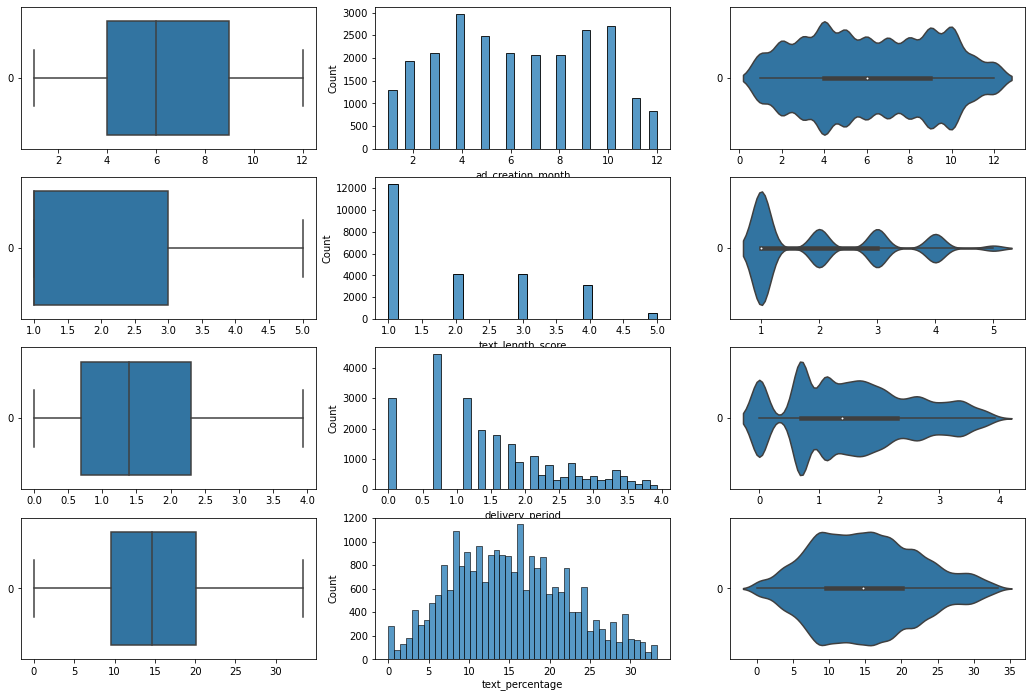

In [66]:
f, axes = plt.subplots(4, 3, figsize=(18, 12))

count = 0
for var in X_train:
    sb.boxplot(data = X_train[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = X_train[var], ax = axes[count,1])
    sb.violinplot(data = X_train[var], orient = "h", ax = axes[count,2])
    count += 1

### Correlation

<AxesSubplot:>

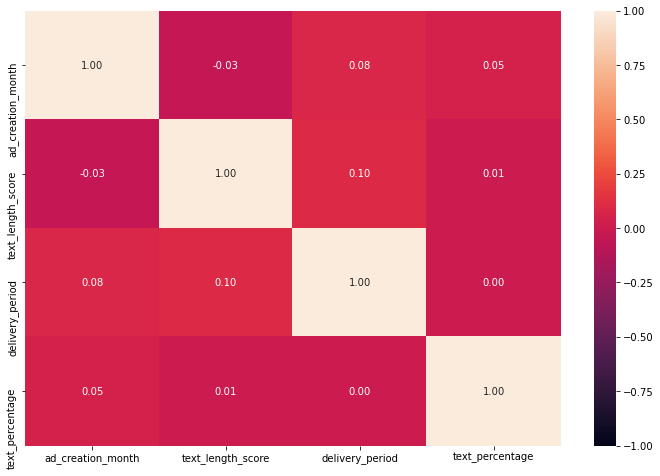

In [67]:
trainDF = pd.concat([y_train, X_train], axis = 1).reindex(y_train.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

## gg :) 

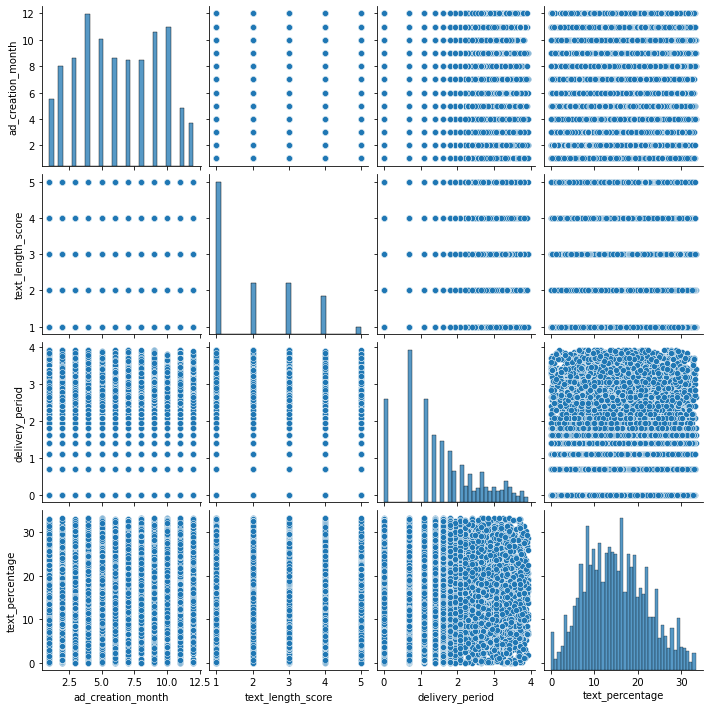

In [68]:
sb.pairplot(data = trainDF)

These parameters do not really affects hahahahhahah

## Model

(array([ 1275.,     0.,  9909.,     0.,     0., 17753.,     0.,  1436.,
            0.,    59.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

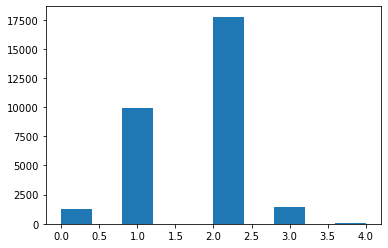

In [69]:
plt.hist(y)

In [70]:
df

,Unnamed: 0,Unnamed: 0.1,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,...,audience_network,demographic_dist,spend_per_day,impressions_per_day,impressions_per_day_log,CPM_scaled,CPM_scaled_sqrt,text_length_score,text_percentage,CPM_scaled_sqrt_bin
0,0,0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,...,0,"[{'percentage': '0.004551', 'age': '18-24', 'g...",2.505526,624.750000,6.437352,389.216887,19.728580,1,19.610181,1
1,1,1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,...,0,"[{'percentage': '0.003058', 'age': '45-54', 'g...",2.505526,124.750000,4.826312,519.138853,22.784619,1,19.610181,2
2,2,2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,...,0,"[{'percentage': '0.001969', 'age': '25-34', 'g...",2.100061,249.833333,5.520794,380.391085,19.503617,1,20.669841,1
3,3,3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,...,0,"[{'percentage': '0.000834', 'age': '45-54', 'g...",1.119232,93.687500,4.539965,246.528692,15.701232,1,22.993093,1
4,4,4,ad-tech,US,108510735095059,Dr. Jennifer Wilson for City Council District 5,512240050437223,2022-04-07,4,2022-04-07,...,0,"[{'percentage': '0.000944', 'age': '25-34', 'g...",2.910633,657.842105,6.488965,448.551190,21.179027,1,23.020000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30961,34868,35593,cyber-security,US,135472729801920,Atlantis University,381289572628044,2018-10-03,10,2018-10-03,...,0,"[{'percentage': '0.000232', 'age': '18-24', 'g...",3.376763,795.409091,6.678857,255.808139,15.994003,1,7.028637,1
30962,34869,35594,cyber-security,US,135472729801920,Atlantis University,517753845398018,2018-10-03,10,2018-10-03,...,0,"[{'percentage': '0.000225', 'age': '18-24', 'g...",4.551697,1323.470588,7.188013,403.297086,20.082258,1,17.986111,2
30963,34870,35595,cyber-security,US,135472729801920,Atlantis University,1251766551633027,2018-10-03,10,2018-10-03,...,0,"[{'percentage': '0.000141', 'age': '18-24', 'g...",4.099504,156.187500,5.051057,514.868168,22.690707,1,8.209660,2
30964,34871,35596,cyber-security,US,135472729801920,Atlantis University,205891737021220,2018-10-03,10,2018-10-03,...,0,NaN,3.891820,1249.900000,7.130819,338.032188,18.385652,1,14.993590,1


In [54]:
df.to_csv('Y:/Internship/SoMin/data/df_cpm_scaled_valid_img2.csv')
utils.save_pickle(df, 'Y:/Internship/SoMin/data/df_cpm_scaled_valid_img2.pkl')

In [73]:
df.CPM_scaled_sqrt_bin.describe()

count     30432
unique        5
top           2
freq      17753
Name: CPM_scaled_sqrt_bin, dtype: int64

In [75]:
y.value_counts()

CPM_scaled_sqrt_bin
2                      17753
1                       9909
3                       1436
0                       1275
4                         59
dtype: int64

In [76]:
X_train

,ad_creation_month,text_length_score,delivery_period,text_percentage
19891,5,1,0.693147,20.424628
12930,4,2,1.791759,8.565000
20949,3,1,0.693147,13.402778
11978,5,1,1.609438,24.607586
25628,7,3,3.465736,14.547684
...,...,...,...,...
13295,4,1,1.098612,29.342222
19963,5,1,0.693147,18.894402
9922,8,3,3.295837,21.451111
10916,7,2,3.367296,20.396943


In [77]:
df = df.dropna(subset=['CPM_scaled_sqrt_bin'])

In [78]:
sum(df['CPM_scaled_sqrt_bin'].isna())

0

In [79]:
df['CPM_scaled_sqrt_bin'].astype('int64')

0        1
1        2
2        1
3        1
4        2
        ..
30961    1
30962    2
30963    2
30964    1
30965    2
Name: CPM_scaled_sqrt_bin, Length: 30432, dtype: int64

In [80]:
# for i in range(df.shape[0]):
# #     if type(df.iloc[i].CPM_scaled_sqrt_bin) != 'int64':
#         print(i, type(df['CPM_scaled_sqrt_bin']))

In [81]:
type(y.iloc[0].CPM_scaled_sqrt_bin)

numpy.int64

In [53]:
# predictor=['ad_creation_month', 'delivery_period']

# target=['CPM_scaled_sqrt_bin']

# X = df[predictor]
# y = df[target]

# y = LabelBinarizer().fit_transform(y)

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
print('SHAPE')
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", len(y_train))
print("y_test:", len(y_test))


xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, verbose=5, objective='multi:softprof', eval_metric=['auc'])
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
y_test_pred_proba = xgb.predict_proba(X_test)
y_train_pred_proba = xgb.predict_proba(X_train)
from sklearn.metrics import mean_squared_error, accuracy_score

print()
print("REPORT")
print("==============")
print("Train accuracy", accuracy_score(y_train, y_train_pred))
print("Test accuracy", accuracy_score(y_test, y_test_pred))
print()
print("Train balanced accuracy_score", balanced_accuracy_score(y_train, y_train_pred))
print("Test_balanced_accuracy_score", balanced_accuracy_score(y_test, y_test_pred))
print()
print("Train auc score", roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr'))
print("Test auc score", roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr'))
print()
print("Train mcc:", matthews_corrcoef(y_train, y_train_pred))
print("Test mcc:", matthews_corrcoef(y_test, y_test_pred))
print()
print("Train classification report:", classification_report(y_train, y_train_pred))
print("Test classification Report:", classification_report(y_test, y_test_pred))


SHAPE
X_train: (24345, 4)
X_test: (6087, 4)
y_train: 24345
y_test: 6087
[21:20:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



REPORT
Train accuracy 0.6786198398028342
Test accuracy 0.5968457368161656

Train balanced accuracy_score 0.357546259563515
Test_balanced_accuracy_score 0.2629527451907351

Train auc score 0.8908606705327307
Test auc score 0.7035866025454717

Train mcc: 0.37071446917744266
Test mcc: 0.11485431703648344

Train classification report:               precision    recall  f1-score   support

           0       0.87      0.19      0.31      1028
           1       0.78      0.33      0.46      8007
           2       0.66      0.96      0.78     14117
           3       0.85      0.09      0.16      1142
           4       0.85      0.22      0.34        51

    accuracy                           0.68     24345
   macro avg       0.80      0.36      0.41     24345
weighted avg       0.72      0.68      0.63     24345

Test classification Report:               precision    recall  f1-score   support

           0       0.50      0.08      0.14       247
           1       0.45      0.18      0

In [105]:
xgb.feature_importances_

array([0.26957995, 0.21666306, 0.21483755, 0.2989194 ], dtype=float32)

In [122]:
# predictor=['ad_creation_month', 'delivery_period']

# target=['CPM_scaled_sqrt_bin']

# X = df[predictor]
# y = df[target]

# y = LabelBinarizer().fit_transform(y)

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
print('SHAPE')
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", len(y_train))
print("y_test:", len(y_test))


lgbm = LGBMClassifier(max_depth=5, random_state=314, silent=True, metric='None', 
                      n_jobs=4, n_estimators=5000, objective='multiclass')
lgbm.fit(X_train, y_train)
y_train_pred = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)
y_test_pred_proba = lgbm.predict_proba(X_test)
y_train_pred_proba = lgbm.predict_proba(X_train)

print()
print("REPORT")
print("==============")
print("Train accuracy", accuracy_score(y_train, y_train_pred))
print("Test accuracy", accuracy_score(y_test, y_test_pred))
print()
print("Train balanced accuracy_score", balanced_accuracy_score(y_train, y_train_pred))
print("Test_balanced_accuracy_score", balanced_accuracy_score(y_test, y_test_pred))
print()
print("Train auc score", roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr'))
print("Test auc score", roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr'))
print()
print("Train mcc:", matthews_corrcoef(y_train, y_train_pred))
print("Test mcc:", matthews_corrcoef(y_test, y_test_pred))
print()
print("Train classification report:", classification_report(y_train, y_train_pred))
print("Test classification Report:", classification_report(y_test, y_test_pred))


SHAPE
X_train: (27388, 4)
X_test: (3044, 4)
y_train: 27388
y_test: 3044

REPORT
Train accuracy 0.8100262888856433
Test accuracy 0.55946123521682

Train balanced accuracy_score 0.7239990765017673
Test_balanced_accuracy_score 0.2734559971424945

Train auc score 0.9609994126114311
Test auc score 0.6822839464484087

Train mcc: 0.6456879758950982
Test mcc: 0.13580391196648794

Train classification report:               precision    recall  f1-score   support

           0       0.86      0.76      0.81      1148
           1       0.82      0.66      0.73      8970
           2       0.80      0.92      0.86     15934
           3       0.84      0.61      0.71      1280
           4       0.76      0.68      0.72        56

    accuracy                           0.81     27388
   macro avg       0.82      0.72      0.76     27388
weighted avg       0.81      0.81      0.80     27388

Test classification Report:               precision    recall  f1-score   support

           0       0.29 

In [120]:
models = {'RandomForest': RandomForestClassifier(),
          'LightGBM': LGBMClassifier(),
          'XGBoost': XGBClassifier()}
result = {}

scoring_metrics = {'f1': make_scorer(f1_score, average='macro'), 
                   'mcc': make_scorer(matthews_corrcoef), 
                   'bal_acc': make_scorer(balanced_accuracy_score), 
                   'acc': make_scorer(accuracy_score)}

for name in models.keys():
    
    model = models[name]
    r = cross_validate(model, X=X, y=y, scoring=scoring_metrics, cv=5, return_estimator=True)
    result[name] = r

C:\Users\root\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\root\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\root\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\root\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was pa

[18:51:52] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:51:55] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:01] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [98]:
first_results = {}
for k in result.keys():
    first_results[k] = {}
    first_results[k]['f1'] = np.mean(result[k]['test_f1'])
    first_results[k]['mcc'] = np.mean(result[k]['test_mcc'])
    first_results[k]['bal_acc'] = np.mean(result[k]['test_bal_acc'])
    first_results[k]['acc'] = np.mean(result[k]['test_acc'])

fr = pd.DataFrame(first_results).transpose()
fr

,f1,mcc,bal_acc,acc
RandomForest,0.181031,-0.074960,0.181275,0.413643
LightGBM,0.162464,-0.090522,0.185792,0.502004
XGBoost,0.157908,-0.119457,0.170633,0.452287


## Feature importance

In [99]:
impt = {}
for k in result.keys():
    if k != 'RandomForest':
        impt[k] = []
        for idx, estimator in enumerate(result[k]['estimator']):
            print(f"{k} features sorted by their score for estimator {idx}:")
            feature_importances = pd.DataFrame(estimator.feature_importances_, index=X.columns, 
                                               columns=['importance']).sort_values('importance', ascending=False)
            impt[k].append(feature_importances)
            print(feature_importances.head(50), end='\n\n')

LightGBM features sorted by their score for estimator 0:
                   importance
text_percentage          6999
delivery_period          3760
ad_creation_month        2715
text_length_score        1526

LightGBM features sorted by their score for estimator 1:
                   importance
text_percentage          7025
delivery_period          3820
ad_creation_month        2703
text_length_score        1452

LightGBM features sorted by their score for estimator 2:
                   importance
text_percentage          6893
delivery_period          3852
ad_creation_month        2701
text_length_score        1554

LightGBM features sorted by their score for estimator 3:
                   importance
text_percentage          7009
delivery_period          3851
ad_creation_month        2615
text_length_score        1525

LightGBM features sorted by their score for estimator 4:
                   importance
text_percentage          7050
delivery_period          3828
ad_creation_month    

## Linear Regression

In [7]:
df.dropna(subset=['CPM_scaled_sqrt'], inplace=True)

In [18]:
predictor=["ad_creation_month", "text_length_score", "delivery_period", "text_percentage"]

target=['CPM_scaled_sqrt']

X = df[predictor]
y = df[target]

# y = LabelBinarizer().fit_transform(y)

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# y_train = np.array(y_train).ravel()
# y_test = np.array(y_test).ravel()
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Root mean square error train:\t", rmse_train)
print("Root mean square error test:\t", rmse_test)
print("Mean value of y_train_pred:\t", np.mean(y_train_pred))
print("Mean value of y_test_pred:\t", np.mean(y_test_pred))
print("Ratio train:\t", rmse_train/np.mean(y_train_pred))
print("Ratio test:\t", rmse_test/np.mean(y_test_pred))

SHAPE
(27400, 4)
(3045, 4)
27400
3045
Root mean square error train:	 5.743769426784071
Root mean square error test:	 5.729289308153735
Mean value of y_train_pred:	 21.26439588502863
Mean value of y_test_pred:	 21.26448525084179
Ratio train:	 0.27011204352285495
Ratio test:	 0.26942995518440455


=> quite ok

For Ashrae standard, a model of prediction has to have an R2 higher than 0.75 and a SI below 30% if we consider annual data and 10% if we consider hourly or monthly data.